# Prompt variability demo notebook
In this notebook we visualize the results of our research on prompt variability in a multilingual setting. Multiple models, tasks, and language constructs (called 'prompt types' below) are evaluated on 3 different languages: English, German, and French. Every prompt type consists of 6-10 prompt variants. Using the plots below, we can find out what works best. 

The experiments were run on 5 models on all constructed prompts (around 420 prompts), and evaluated on batches of 200 sentences per prompt. The output logits were saved into pickle files which we load in in this notebook to plot  evaluation metrics across these experiments. Then, we can analyze our results to compare the performance of different prompts and prompt structures.

### Example prompts for Sentiment Analysis:

* **"Review: {content} \n Is this review positive? Yes or no? \n Answer:"**
* **"Bewertung: {content} \n Wird diese Bewertung als positiv angesehen? Ja oder nein? \n Antwort:"**
* **"Critique: {content} \n L'utilisateur a-t-il rédigé une critique positive? Oui ou non? \n Réponse:"**

### Example prompts for Natural Language Inference:

* **"Premise: {premise} \n Take this premise as truth. Does this truth entail the following statement: {hypothesis}? Yes, no or maybe? \n Answer:"**
* **"Nehmen Sie das Folgende als wahr an: {premise} \n Könnte diese Wahrheit die folgende Aussage implizieren: {hypothesis}? Ja, nein oder vielleicht? \n Antwort:"**
* **Présumez que ce qui suit est véridique: {premise} \n En conséquence, est-ce que cela entraîne également: {hypothesis}? Oui, non ou peut-être? \n Réponse:**

# Imports and experiment settings

Here we import libraries and copy the experimental configuration used in all of our experiments (i.e. generally stays the same across all experiments). The configuration simply describes which models we are using, which prompt types, which languages, the seeds and the task.

In [2]:
! pip install pingouin

import os
import matplotlib.pyplot as plt
import pickle
import torch

import statistics
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
import io
import plotly.graph_objects as go
import plotly.express as px
import statistics
from scipy import stats
import random
from google.colab import drive
from copy import deepcopy
import pingouin as pg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=0fb3237e8f8b5e6c724c6186604e26547b6a4e63fb3284d0ef494881009ccdd0
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [3]:
### experiment settings

significance_p_value_cutoff = 0.05
SA_chance = 0.5
NLI_chance = 0.33333
# these baselines were pre-computed, based on the settings underneath it
SA_baselines = [[[0.54], [0.625], [0.525], [0.585], [0.7]], [[0.5], [0.5], [0.54], [0.55], [0.47]], [[0.5], [0.535], [0.675], [0.51], [0.765]]]
NLI_baselines = [[[0.30808080808080807], [0.36363636363636365], [0.3333333333333333], [0.3383838383838384], [0.3333333333333333]], [[0.3181818181818182], [0.3282828282828283], [0.3484848484848485], [0.37373737373737376], [0.3686868686868687]], [[0.37373737373737376], [0.3686868686868687], [0.3838383838383838], [0.3939393939393939], [0.3434343434343434]]]

models = ["bloom", "bloomz", "flan", "llama", "t0"]
seed = '42'
tasks = ["SA", "NLI"]
languages = ["fr", "de", "en"]
prompt_types = ['active', 'passive', 'auxiliary', 'modal', 'common', 'rare_synonyms', 'identical_modal']
prompt_type_pairs = [('active', 'passive'), ('auxiliary', 'modal'), ('common', 'rare_synonyms')]

answer_translation_dict = {'en':{'yes':'yes', 'no':'no', 'maybe':'maybe'},
                           'de':{'yes':'ja', 'no':'nein', 'maybe':'vielleicht'},
                           'fr':{'yes':'oui', 'no':'non', 'maybe':'peut-être'}}

In [4]:
# dict containing omplete prompt structure used in experiments
PROMPT_STRUCTURE = {"en": {"SA": {"active": ['Review: {content} \n Is this review positive? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Does this review sound positive? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Did the user write a positive review? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Does this product review reflect positivity? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Does the user recommend the product? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Does this product review convey positive sentiment? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Does this product review have a positive tone? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Here is a review of a product left by a customer. Do you consider this review to be positive? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Can you say this review depicts the product in a positive light? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Does the reviewer express positive sentiment for the product? Possible answers: \n A yes \n B no \n Answer:'
                                             ],
                                  "passive": ['Review: {content} \n Is this review considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                              'Review: {content} \n Is this review regarded to sound positive? Possible answers: \n A yes \n B no \n Answer:',
                                              'Review: {content} \n Was this review written positively by the user? Possible answers: \n A yes \n B no \n Answer:',
                                              'Review: {content} \n Is this product review characterized by positivity? Possible answers: \n A yes \n B no \n Answer:',
                                              'Review: {content} \n Is the review written by the user to recommend the product? Possible answers: \n A yes \n B no \n Answer:',
                                              'Review: {content} \n Is positive sentiment conveyed by this product review? Possible answers: \n A yes \n B no \n Answer:',
                                              'Review: {content} \n Is this review written with a positive tone? Possible answers: \n A yes \n B no \n Answer:',
                                              'Review: {content} \n Here is a review of a product left by a customer. Is this review considered to be positive? Possible answers: \n A yes \n B no \n Answer:',
                                              'Review: {content} \n Can you say the product in this review is depicted in a positive light? Possible answers: \n A yes \n B no \n Answer:',
                                              'Review: {content} \n Is positive sentiment expressed by the reviewer for the product? Possible answers: \n A yes \n B no \n Answer:'
                                              ],
                                  "auxiliary": ['Review: {content} \n Is this review positive? Possible answers: \n A yes \n B no \n Answer:',
                                                'Review: {content} \n Do you consider this review positive? Possible answers: \n A yes \n B no \n Answer:',
                                                'Review: {content} \n Did the user write a positive review? Possible answers: \n A yes \n B no \n Answer:',
                                                'Review: {content} \n Based on this review, does the user recommend the product? Possible answers: \n A yes \n B no \n Answer:',
                                                'Review: {content} \n Does this product review convey positive sentiment? Possible answers: \n A yes \n B no \n Answer:',
                                                'Review: {content} \n Does this product review have a positive tone? Possible answers: \n A yes \n B no \n Answer:',
                                                'Review: {content} \n Here is a review of a product left by a customer. Do you consider this review positive? Possible answers: \n A yes \n B no \n Answer:',
                                                'Review: {content} \n Does the reviewer express positive sentiment for the product? Possible answers: \n A yes \n B no \n Answer:',
                                                'Review: {content} \n Does the user think positively about the product? Possible answers: \n A yes \n B no \n Answer:',
                                                'Review: {content} \n Is positive sentiment expressed in this review? Possible answers: \n A yes \n B no \n Answer:'
                                                ],
                                  "modal": ['Review: {content} \n Could this review be positive? Possible answers: \n A yes \n B no \n Answer:',
                                            'Review: {content} \n Would you consider this review positive? Possible answers: \n A yes \n B no \n Answer:',
                                            'Review: {content} \n Could the user have written a positive review? Possible answers: \n A yes \n B no \n Answer:',
                                            'Review: {content} \n Based on this review, might the user be recommending the product? Possible answers: \n A yes \n B no \n Answer:',
                                            'Review: {content} \n May this product review be conveying positive sentiment? Possible answers: \n A yes \n B no \n Answer:',
                                            'Review: {content} \n Might this product review have a positive tone? Possible answers: \n A yes \n B no \n Answer:',
                                            'Review: {content} \n Here is a review of a product left by a customer. Can you consider this review positive? Possible answers: \n A yes \n B no \n Answer:',
                                            'Review: {content} \n Could the reviewer be expressing positive sentiment for the product? Possible answers: \n A yes \n B no \n Answer:',
                                            'Review: {content} \n Must the user think positively about the product? Possible answers: \n A yes \n B no \n Answer:',
                                            'Review: {content} \n Must positive sentiment be expressed in this review? Possible answers: \n A yes \n B no \n Answer:'
                                            ],
                                  "common": ['Review: {content} \n Do you consider this review to be positive? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Did the user write a positive review? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Does the reviewer express positive sentiment for the product? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Here is a review of a product left by a customer. Can this review be classified as positive? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Based on this review, could the user be recommending the product? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Would you say this review is positive? Possible answers: \n A yes \n B no \n Answer:',
                                             'Review: {content} \n Does this product review have a positive tone? Possible answers: \n A yes \n B no \n Answer:'
                                             ],
                                  "rare_synonyms": ['Review: {content} \n Do thou envision this review to be positive? Possible answers: \n A yes \n B no \n Answer:',
                                                    'Review: {content} \n Did the purchaser compose a positive review? Possible answers: \n A yes \n B no \n Answer:',
                                                    'Review: {content} \n Does the reviewer connote a positive disposition towards the product? Possible answers: \n A yes \n B no \n Answer:',
                                                    'Review: {content} \n Here is a review of a commodity fabricated by a purchaser. May this review be categorized as positive? Possible answers: \n A yes \n B no \n Answer:',
                                                    'Review: {content} \n Revolving this review, could the shopper be advocating the product? Possible answers: \n A yes \n B no \n Answer:',
                                                    'Review: {content} \n Would thou hypothesize that the preceding review is positive? Possible answers: \n A yes \n B no \n Answer:',
                                                    'Review: {content} \n Does this commodity review have a positive tenor? Possible answers: \n A yes \n B no \n Answer:'
                                                    ],
                                  "identical_modal": ['Review: {content} \n Can this review be considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                                      'Review: {content} \n Could this review be considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                                      'Review: {content} \n May this review be considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                                      'Review: {content} \n Might this review be considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                                      'Review: {content} \n Shall this review be considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                                      'Review: {content} \n Should this review be considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                                      'Review: {content} \n Will this review be considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                                      'Review: {content} \n Would this review be considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                                      'Review: {content} \n Must this review be considered positive? Possible answers: \n A yes \n B no \n Answer:',
                                                      'Review: {content} \n Ought this review be considered positive? Possible answers: \n A yes \n B no \n Answer:'
                                                      ]},

                           "NLI": {"active": ['Premise: {premise} \n Take this premise as truth. Does this truth entail the following statement: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              'Given the premise: {premise} \n Do we assume that this is true: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              'Given the premise: {premise} \n Does this premise infer this to be true: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              '{premise} \n Can we say that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              'Assume this premise is true: {premise}, \n Therefore, is the following true: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              'Premise: {premise} \n Question: Does this premise imply that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              'Suppose this premise is true: {premise} \n Can we infer that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              '{premise} \n Based on the previous passage, does it entail the following: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              '{premise} \n Based on the information above, can we infer the following: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              'Consider the following: {premise} \n Does the previous text entail the following: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:'
                                              ],
                                   "passive": ['Premise: {premise}, \n This premise is taken as truth. Is the following statement entailed by this truth: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                               'Given the premise: {premise} \n Is it assumed that this is true {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                               'Given the premise: {premise} \n Is it inferred by this premise for this to be true: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                               '{premise} \n Can it be said that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                               'This premise is assumed to be true: {premise}, \n Therefore, can the following be considered true: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                               'Premise: {premise} \n Question: Is it implied by this premise that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                               'This premise is supposed to be true: {premise} \n Can it be inferred that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                               '{premise} \n Based on the previous passage, is the following entailed: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                               '{premise} \n Based on the information above, can the following be inferred: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                               'The following is considered: {premise} \n Is the following entailed by the previous text: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:'
                                               ],
                                   "auxiliary": ['Take the following as truth: {premise} \n Does this truth entail the following statement: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                 'Given: {premise}, \n Do we assume that it is true that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                 'Assume the following is true: {premise}, \n Therefore, is it entailed that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                 '{premise} \n Question: Does the previous text imply that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                 '{premise} \n Based on the previous passage, is it inferred that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                 '{premise} \n Going from the previous information, is this implied: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                 'Take the following as truth: {premise}, \n Is the following statement entailed by this truth: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                 'Suppose this is true: {premise}. \n Is it be inferred that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                 'It is assumed true that: {premise} \n Therefore, do we also assume that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                 '{premise} \n Do we say the previous entails the following: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:'
                                                 ],
                                   "modal": ['Take the following as truth: {premise} \n Could this truth entail the following statement: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                             'Given: {premise} \n Can we assume that it is true that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                             'Assume the following must be true: {premise}, \n Therefore, must it be entailed that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                             '{premise} \n Question: Would the previous text imply that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                             '{premise} \n Based on the previous passage, could it be inferred that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                             '{premise} \n Going from the previous information, can this be implied: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                             'Take the following as truth: {premise}, \n Should the following statement be entailed by this truth: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                             'Suppose this is true: {premise}. \n Might it be inferred that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                             'It is assumed true that: {premise} \n Therefore, ought we also assume that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                             '{premise} \n May we say the previous entails the following: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:'
                                             ],
                                   "common": ['Assume it is true that: {premise} \n Therefore, does it also entail: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              '{premise} \n Based on that information, is the following claim entailed: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              '{premise} \n Question: would this also imply that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              'Suppose {premise} \n Can it be inferred that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              '{premise} \n Based on the previous passage, must the following hold: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              'Suppose the following is true: {premise} \n Can we infer that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                              'Take the following as truth: {premise} \n could the following statement be entailed by it: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:'
                                              ],
                                   "rare_synonyms": ['Hypothesize the following is truthful: {premise} \n Consequently, does it conjointly entail: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                     '{premise} \n Grounded in that information, is the following postulation entailed: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                     '{premise} \n Question: would this furthermore signify that {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                     'Presume {premise} \n Can it be construed that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                     '{premise} \n Proceeding from the aforementioned passage, must the following hold: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                     'Presume the ensuing is true: {premise} \n Can we deduce that: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                     'Perceive the following as truth: {premise} \n is the following narrative entailed by it: {hypothesis}? Possible answers: \n A yes \n B no \n C neutral \n Answer:'
                                                     ],
                                   "identical_modal": ['Given: {premise} \n Can we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                       'Given: {premise} \n Could we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                       'Given: {premise} \n May we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                       'Given: {premise} \n Might we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                       'Given: {premise} \n Shall we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                       'Given: {premise} \n Should we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                       'Given: {premise} \n Will we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                       'Given: {premise} \n Would we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                       'Given: {premise} \n Must we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:',
                                                       'Given: {premise} \n Ought we assume that: {hypothesis} Possible answers: \n A yes \n B no \n C neutral \n Answer:'
                                                       ]}},

                    "de": {"SA": {"active": ['Bewertung: {content} \n Ist diese Bewertung positiv? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                             'Bewertung: {content} \n Klingt diese Bewertung positiv? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                             'Bewertung: {content} \n Hat der Benutzer eine positive Bewertung geschrieben? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                             'Bewertung: {content} \n Spiegelt diese Produktbewertung Positivität wider? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                             'Bewertung: {content} \n Empfiehlt der Benutzer das Produkt? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                             'Bewertung: {content} \n Vermittelt diese Produktbewertung positive Stimmung? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                             'Bewertung: {content} \n Hat diese Produktbewertung einen positiven Ton? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                             'Bewertung: {content} \n Hier ist eine Bewertung eines Produkts, die von einem Kunden abgegeben wurde. Halten Sie diese Bewertung für positiv? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                             'Bewertung: {content} \n Kann man sagen, dass diese Bewertung das Produkt positiv darstellt? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                             'Bewertung: {content} \n Drückt der Bewerter positive Stimmung für das Produkt aus? Mögliche Antworten: \n A ja \n B nein \n Antwort:'
                                             ],
                                  "passive": ['Bewertung: {content} \n Wird diese Bewertung als positiv angesehen? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                              'Bewertung: {content} \n Wird diese Bewertung als positiv betrachtet? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                              'Bewertung: {content} \n Wurde diese Bewertung positiv vom Benutzer geschrieben? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                              'Bewertung: {content} \n Wird diese Produktbewertung als positiv charakterisiert? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                              'Bewertung: {content} \n Wird die Bewertung vom Benutzer empfohlen, um das Produkt zu kaufen? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                              'Bewertung: {content} \n Wird durch diese Produktbewertung positive Stimmung vermittelt? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                              'Bewertung: {content} \n Wird durch diese Bewertung ein positiver Ton vermittelt? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                              'Bewertung: {content} \n Hier ist eine Bewertung eines Produkts, die von einem Kunden abgegeben wurde. Wird diese Bewertung als positiv angesehen? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                              'Bewertung: {content} \n Kann man sagen, dass das Produkt in dieser Bewertung positiv dargestellt wird? Mögliche Antworten: \n A ja \n B nein \n Antwort:',
                                              'Bewertung: {content} \n Wird positive Stimmung für das Produkt vom Bewerter ausgedrückt? Mögliche Antworten: \n A ja \n B nein \n Antwort:'
                                              ],
                                  "auxiliary": ["Bewertung: {content} \n Drückt diese Bewertung positive Stimmung aus? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                "Bewertung: {content} \n Betrachten Sie diese Bewertung als positiv? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                "Bewertung: {content} \n Hat der Benutzer eine positive Bewertung geschrieben? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                "Bewertung: {content} \n Empfiehlt der Benutzer das Produkt aufgrund dieser Bewertung? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                "Bewertung: {content} \n Vermittelt diese Produktbewertung positive Stimmung? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                "Bewertung: {content} \n Hat diese Produktbewertung einen positiven Ton? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                "Bewertung: {content} \n Hier ist eine Bewertung eines Produkts, die von einem Kunden abgegeben wurde. Betrachten Sie diese Bewertung als positiv? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                "Bewertung: {content} \n Drückt der Bewerter positive Stimmung für das Produkt aus? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                "Bewertung: {content} \n Denkt der Benutzer positiv über das Produkt? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                "Bewertung: {content} \n Wird in dieser Bewertung positive Stimmung ausgedrückt? Mögliche Antworten: \n A ja \n B nein \n Antwort:"
                                                ],
                                  "modal": ["Bewertung: {content} \n Könnte diese Bewertung positiv sein? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                            "Bewertung: {content} \n Würden Sie diese Bewertung als positiv betrachten? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                            "Bewertung: {content} \n Könnte der Benutzer eine positive Bewertung geschrieben haben? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                            "Bewertung: {content} \n Könnte der Benutzer aufgrund dieser Bewertung das Produkt empfehlen? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                            "Bewertung: {content} \n Könnte diese Produktbewertung positive Stimmung vermitteln? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                            "Bewertung: {content} \n Könnte diese Produktbewertung einen positiven Ton haben? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                            "Bewertung: {content} \n Hier ist eine Bewertung eines Produkts, die von einem Kunden abgegeben wurde. Können Sie diese Bewertung als positiv betrachten? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                            "Bewertung: {content} \n Könnte der Bewerter positive Stimmung für das Produkt ausdrücken? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                            "Bewertung: {content} \n Muss der Benutzer positiv über das Produkt denken? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                            "Bewertung: {content} \n Muss in dieser Bewertung positive Stimmung ausgedrückt werden? Mögliche Antworten: \n A ja \n B nein \n Antwort:"
                                            ],
                                  "common": ["Bewertung: {content} \n Betrachten Sie diese Bewertung als positiv? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                             "Bewertung: {content} \n Hat der Benutzer eine positive Bewertung geschrieben? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                             "Bewertung: {content} \n Drückt der Rezensent positive Stimmung für das Produkt aus? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                             "Bewertung: {content} \n Hier ist eine Bewertung eines Produkts, die von einem Kunden hinterlassen wurde. Kann diese Bewertung als positiv eingestuft werden? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                             "Bewertung: {content} \n Könnte der Benutzer basierend auf dieser Bewertung das Produkt empfehlen? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                             "Bewertung: {content} \n Würden Sie sagen, dass diese Bewertung positiv ist? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                             "Bewertung: {content} \n Hat diese Produktbewertung einen positiven Ton? Mögliche Antworten: \n A ja \n B nein \n Antwort:"
                                             ],
                                  "rare_synonyms": ["Bewertung: {content} \n Begutachtest du diese Bewertung als bejahend? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                    "Bewertung: {content} \n Hat der Käufer eine positive Bewertung verfasst? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                    "Bewertung: {content} \n Drückt der Rezensent eine positive Haltung gegenüber dem Produkt aus? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                    "Bewertung: {content} \n Hier ist eine Bewertung eines Fabrikat, die von einem Käufer kreiert wurde. Kann diese Bewertung als positiv kategorisiert werden? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                    "Bewertung: {content} \n Drehend diese Bewertung, könnte der Käufer das Produkt befürworten? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                    "Bewertung: {content} \n Würdest du vermuten, dass die vorherige Bewertung positiv ist? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                    "Bewertung: {content} \n Hat diese Warenbewertung eine positive Ausrichtung? Mögliche Antworten: \n A ja \n B nein \n Antwort:"
                                                    ],
                                  "identical_modal": ["Bewertung: {content} \n Dürfen diese Bewertung als positiv betrachtet werden? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                      "Bewertung: {content} \n Können diese Bewertung als positiv betrachtet werden? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                      "Bewertung: {content} \n Möchten diese Bewertung als positiv betrachtet werden? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                      "Bewertung: {content} \n Müssen diese Bewertung als positiv betrachtet werden? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                      "Bewertung: {content} \n Wollen diese Bewertung als positiv betrachtet werden? Mögliche Antworten: \n A ja \n B nein \n Antwort:",
                                                      "Bewertung: {content} \n Sollen diese Bewertung als positiv betrachtet werden? Mögliche Antworten: \n A ja \n B nein \n Antwort:"
                                                      ]},

                           "NLI": {"active": ['Prämisse: {premise} \n Nehmen Sie diese Prämisse als Wahrheit an. Impliziert diese Wahrheit die folgende Aussage: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              'Gegeben die Prämisse: {premise} \n Gehen wir davon aus, dass dies wahr ist: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              'Gegeben die Prämisse: {premise} \n Impliziert diese Prämisse, dass dies wahr ist: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              '{premise} \n Können wir sagen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              'Nehmen Sie diese Prämisse als wahr an: {premise}, \n Ist dann das Folgende wahr: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              'Prämisse: {premise} \n Frage: Impliziert diese Prämisse, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              'Nehmen wir an, diese Prämisse ist wahr: {premise} \n Können wir daraus schließen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              '{premise} \n Basierend auf dem vorherigen Abschnitt, impliziert es das Folgende: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              '{premise} \n Basierend auf den obigen Informationen, können wir daraus schließen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              'Betrachten Sie Folgendes: {premise} \n Impliziert der vorherige Text das Folgende: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:'
                                              ],
                                   "passive": ['Prämisse: {premise}, \n Diese Prämisse wird als Wahrheit angenommen. Wird die folgende Aussage durch diese Wahrheit impliziert: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                               'Gegeben die Prämisse: {premise} \n Wird angenommen, dass dies wahr ist: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                               'Gegeben die Prämisse: {premise} \n Wird durch diese Prämisse impliziert, dass dies wahr ist: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                               '{premise} \n Kann gesagt werden, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                               'Diese Prämisse wird als wahr angenommen: {premise}, \n Kann daher das Folgende als wahr betrachtet werden: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                               'Prämisse: {premise} \n Frage: Wird durch diese Prämisse impliziert, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                               'Diese Prämisse wird als wahr angenommen: {premise} \n Kann daraus geschlossen werden, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                               '{premise} \n Basierend auf dem vorherigen Abschnitt, wird das Folgende impliziert: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                               '{premise} \n Basierend auf den obigen Informationen, kann daraus geschlossen werden, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                               'Folgendes wird betrachtet: {premise} \n Wird das Folgende durch den vorherigen Text impliziert: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:'
                                               ],
                                   "auxiliary": ['Nehmen Sie das Folgende als wahr an: {premise} \n Impliziert diese Wahrheit die folgende Aussage: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                 'Gegeben: {premise}, \n Gehen wir davon aus, dass es wahr ist, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                 'Nehmen Sie an, dass das Folgende wahr ist: {premise}, \n Ist es daher zwingend, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                 '{premise} \n Frage: Impliziert der vorherige Text, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                 '{premise} \n Basierend auf dem vorherigen Abschnitt, wird daraus geschlossen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                 '{premise} \n Aus den vorherigen Informationen ergibt sich, dass dies impliziert wird: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                 'Nehmen Sie das Folgende als wahr an: {premise}, \n Wird die folgende Aussage durch diese Wahrheit bedingt: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                 'Angenommen, dies ist wahr: {premise}. \n Kann daraus geschlossen werden, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                 'Es wird angenommen, dass es wahr ist: {premise} \n Daher nehmen wir auch an, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                 '{premise} \n Sagen wir, dass das Vorherige das Folgende bedingt: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:'
                                                 ],
                                   "modal": ['Nehmen Sie das Folgende als wahr an: {premise} \n Könnte diese Wahrheit die folgende Aussage implizieren: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                             'Gegeben: {premise} \n Können wir davon ausgehen, dass es wahr ist, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                             'Wir nehmen an, dass das Folgende wahr sein muss: {premise}, \n Muss es daher zwingend sein, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                             '{premise} \n Frage: Würde der vorherige Text implizieren, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                             '{premise} \n Basierend auf dem vorherigen Abschnitt, könnte daraus geschlossen werden, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                             '{premise} \n Aus den vorherigen Informationen heraus, könnte dies impliziert werden: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                             'Nehmen Sie das Folgende als wahr an: {premise}, \n Sollte die folgende Aussage durch diese Wahrheit bedingt sein: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                             'Angenommen, dies ist wahr: {premise}. \n Könnte daraus geschlossen werden, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                             'Es wird angenommen, dass es wahr ist: {premise} \n Sollten wir Daher auch annehmen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                             '{premise} \n Können wir sagen, dass das Vorherige das Folgende bedingt: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:'
                                             ],
                                   "common": ['Nehmen wir an, es ist wahr, dass: {premise} \n Daher impliziert es auch: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              '{premise} \n Basierend auf diesen Informationen, wird die folgende Aussage impliziert: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              '{premise} \n Frage: Würde dies auch bedeuten, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              'Angenommen: {premise} \n Kann daraus geschlossen werden, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              '{premise} \n Basierend auf dem vorherigen Abschnitt, muss die folgende Aussage gelten: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              'Angenommen, das Folgende ist wahr: {premise} \n Können wir daraus schließen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                              'Nehmen wir das Folgende als Wahrheit an: {premise} \n Könnte die folgende Aussage daraus abgeleitet werden: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:'
                                              ],
                                   "rare_synonyms": ['Stellen Sie die folgende Behauptung auf: {premise} \n Folglich impliziert es auch: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                     '{premise} \n Gestützt auf diesen Kenntnisse, wird die folgende Annahme beinhaltet: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                     '{premise} \n Anliegen: Würde dies auch signalisieren, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                     'Vorausgesetzt: {premise} \n Kann daraufhin geschlussfolgert werden, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                     '{premise} \n Ausgehend von dem oben genannten Segment, muss die folgende Stellungnahme gelten: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                     'Vorausgesetzt, das Anschließende ist wahr: {premise} \n Können wir infolgedessen ableiten, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:',
                                                     'Betrachten Sie das Anschließende als Wahrheit: {premise} \n Könnte die hierauffolgende Erzählung infolgedessen abgezogen werden: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:'
                                                     ],
                                   "identical_modal": ["Angesichts der: {premise} \n Dürfen wir annehmen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:",
                                                       "Angesichts der: {premise} \n Können wir annehmen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:",
                                                       "Angesichts der: {premise} \n Möchten wir annehmen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:",
                                                       "Angesichts der: {premise} \n Müssen wir annehmen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:",
                                                       "Angesichts der: {premise} \n Wollen wir annehmen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:",
                                                       "Angesichts der: {premise} \n Sollen wir annehmen, dass: {hypothesis}? Mögliche Antworten: \n A ja \n B nein \n C neutral \n Antwort:",
                                                       ]}},

                    "fr": {"SA": {"active": ["Critique: {content} \n Cette critique est-elle positive? Réponses possibles: \n A oui \n B non \n Reponse:",
                                             "Critique: {content} \n Est-ce que cette critique donne une impression positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             "Critique: {content} \n L'utilisateur a-t-il rédigé une critique positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             "Critique: {content} \n Est-ce que cette critique de ce produit reflète la positivité? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             "Critique: {content} \n L'utilisateur recommande-t-il le produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             "Critique: {content} \n Est-ce que cette critique du produit transmet un sentiment positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             "Critique: {content} \n Cette critique du produit a-t-elle un ton positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             "Critique: {content} \n Voici un avis sur un produit laissé par un client. Considérez-vous cet avis comme positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             "Critique: {content} \n Pouvez-vous dire que cette critique présente le produit sous un jour positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             "Critique: {content} \n Est-ce que le critique exprime un sentiment positif envers le produit? Réponses possibles: \n A oui \n B non \n Réponse:"
                                             ],
                                  "passive": ["Critique: {content} \n Est-ce que cette critique est considérée comme positive? Réponses possibles: \n A oui \n B non \n Reponse:",
                                              "Critique: {content} \n Est-ce que cette critique est considérée comme ayant un ton positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                              "Critique: {content} \n Est-ce que cette critique a été rédigée de manière positive par l'utilisateur? Réponses possibles: \n A oui \n B non \n Réponse:",
                                              "Critique: {content} \n Cette critique du produit est-elle caractérisée par la positivité? Réponses possibles: \n A oui \n B non \n Réponse:",
                                              "Critique: {content} \n La critique écrite par l'utilisateur recommande-t-elle le produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                              "Critique: {content} \n Est-ce que le sentiment positif est véhiculé par cet avis sur le produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                              "Critique: {content} \n Cette critique est-elle rédigée avec un ton positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                              "Critique: {content} \n Voici un avis sur un produit laissé par un client. Est-ce que cette critique est considérée comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                              "Critique: {content} \n Pouvez-vous dire que le produit dans cette critique est présenté sous un jour positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                              "Critique: {content} \n Est-ce que le produit est considéré positivement par le critique? Réponses possibles: \n A oui \n B non \n Réponse:"
                                              ],
                                  "auxiliary": ["Critique: {content} \n Cette critique est-elle positive? Réponses possibles: \n A oui \n B non \n Reponse:",
                                                "Critique: {content} \n Considérez-vous cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                "Critique: {content} \n L'utilisateur a-t-il rédigé une critique positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                "Critique: {content} \n D'après cette critique, est-ce que l'utilisateur recommande le produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                "Critique: {content} \n Est-ce que cette critique du produit transmet un sentiment positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                "Critique: {content} \n Cette critique du produit a-t-elle un ton positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                "Critique: {content} \n Voici un avis sur un produit laissé par un client. Considérez-vous cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                "Critique: {content} \n Est-ce que le critique exprime un sentiment positif envers le produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                "Critique: {content} \n Est-ce que l'utilisateur pense positivement du produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                "Critique: {content} \n Est-ce que ce critique exprime un sentiment positif? Réponses possibles: \n A oui \n B non \n Réponse:"
                                                ],
                                  "modal": ["Critique: {content} \n Est-ce que cette critique pourrait être positive? Réponses possibles: \n A oui \n B non \n Reponse:",
                                            "Critique: {content} \n Pourriez-vous considérer cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                            "Critique: {content} \n L'utilisateur aurait-il pu rédiger une critique positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                            "Critique: {content} \n D'après cette critique, est-ce que l'utilisateur pourrait recommander le produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                            "Critique: {content} \n Est-ce que cette critique du produit pourrait transmettre un sentiment positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                            "Critique: {content} \n Est-ce que cette critique du produit pourrait avoir un ton positif? Réponses possibles: \n A oui \n B non \n Réponse:",
                                            "Critique: {content} \n Voici un avis sur un produit laissé par un client. Pouvez-vous considérer cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                            "Critique: {content} \n Est-ce que le critique pourrait exprimer un sentiment positif envers le produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                            "Critique: {content} \n L'utilisateur doit-il penser positivement du produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                            "Critique: {content} \n Est-ce que ce commentaire doit exprimer un sentiment positif? Réponses possibles: \n A oui \n B non \n Réponse:"
                                            ],
                                  "common": ['Critique: {content} \n Considérez-vous cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:',
                                             "Critique: {content} \n L'utilisateur a-t-il rédigé une critique positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             'Critique: {content} \n Est-ce que le critique exprime un sentiment positif envers le produit? Réponses possibles: \n A oui \n B non \n Réponse:',
                                             'Critique: {content} \n Voici un avis sur un produit laissé par un client. Est-ce que cette critique peut être classée comme positive? Réponses possibles: \n A oui \n B non \n Réponse:',
                                             "Critique: {content} \n D'après cette critique, est-ce que l'utilisateur pourrait recommander le produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                             'Critique: {content} \n Diriez-vous que cette critique est positive? Réponses possibles: \n A oui \n B non \n Réponse:',
                                             'Critique: {content} \n Est-ce que cette critique du produit a un ton positif? Réponses possibles: \n A oui \n B non \n Réponse:'
                                             ],
                                  "rare_synonyms": ["Critique: {content} \n Estimes-tu cette critique comme étant favorable? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                    "Critique: {content} \n L'acheteur a-t-il rédigé une critique positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                    "Critique: {content} \n Est-ce que le critique connote une disposition positive envers le produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                    "Critique: {content} \n Voici un avis sur une marchandise fabriquée par un acheteur. Est-ce que cette critique peut être catégorisée comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                    "Critique: {content} \n En examinant cette critique, est-ce que l'acheteur pourrait faire la promotion du produit? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                    "Critique: {content} \n Penserais-tu que la critique précédente est positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                    "Critique: {content} \n Est-ce que cette critique de la marchandise a un ton positif? Réponses possibles: \n A oui \n B non \n Réponse:"
                                                    ],
                                  "identical_modal": ["Critique: {content} \n Pourrait-on considérer cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                      "Critique: {content} \n Peut-on considérer cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                      "Critique: {content} \n Doit-on considérer cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                      "Critique: {content} \n Saurait-on considérer cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                      "Critique: {content} \n Il faudrait considérer cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:",
                                                      "Critique: {content} \n Oserait-on considérer cette critique comme positive? Réponses possibles: \n A oui \n B non \n Réponse:"
                                                      ]},

                           "NLI": {"active": ["Prémisse: {premise} \n Prends cette prémisse comme vérité. Cette vérité implique-t-elle l'affirmation suivante: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "Étant donné la prémisse: {premise} \n Supposons-nous que cela soit vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "Étant donné la prémisse: {premise} \n Est-ce que cette prémisse laisse entendre que cela est vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "{premise} \n Peut-on dire que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "Supposez que cette prémisse soit vraie: {premise}, \n Par conséquent, est-ce que ce qui suit est vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "Prémisse: {premise} \n Est-ce que cette prémisse implique que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "Supposons que cette prémisse soit vraie: {premise} \n Peut-on déduire que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "{premise} \n Sur la base du passage précédent, cela entraîne-t-il ce qui suit: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "{premise} \n En se basant sur les informations ci-dessus, peut-on déduire ce qui suit: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "Considérez ce qui suit: {premise} \n Le texte précédent entraîne-t-il ce qui suit: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:"
                                              ],
                                   "passive": ["Prémisse: {premise}, \n Cette prémisse est considérée comme étant vraie. Le fait suivant est-il entraîné par cette vérité: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                               "Étant donné la prémisse: {premise} \n Est-il supposé que ceci est vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                               "Étant donné la prémisse {premise} \n Est-il déduit par cette prémisse que ceci est vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                               "{premise} \n Est-il possible de dire que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                               "Cette prémisse est supposée être vraie: {premise}, \n Par conséquent, peut-on considérer ce qui suit comme étant vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                               "Prémisse: {premise} \n Est-il sous-entendu par cette prémisse que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                               "Cette prémisse est supposée être vraie: {premise} \n Peut-il être déduit que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                               "{premise} \n En se basant sur le passage précédent, est-ce que ce qui suit est impliqué: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                               "{premise} \n En se basant sur les informations ci-dessus, est-ce que ce qui suit peut être déduit: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                               "Ce qui suit est considéré: {premise} \n Est-ce que ce qui suit est impliqué par le texte précédent: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:"
                                               ],
                                   "auxiliary": ["Prenez ce qui suit comme vérité: {premise} \n Cette vérité implique-t-elle l'affirmation suivante: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                 "Étant donné: {premise}, \n Supposons-nous que cela soit vrai que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                 "Supposez que ce qui suit est vrai: {premise}, \n Par conséquent, est-il impliqué que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                 "{premise} \n Le texte précédent implique-t-il que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                 "{premise} \n En se basant sur le passage précédent, est-il inféré que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                 "{premise} \n En se basant sur les informations précédentes, est-ce que cela est implicite: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                 "Prenez ce qui suit comme vérité: {premise}, \n La déclaration suivante est-elle engendrée par cette vérité: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                 "Supposons que ceci soit vrai: {premise}. \n Est-il possible de déduire que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                 "On suppose que c'est vrai que: {premise} \n Par conséquent, supposons-nous également que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                 "{premise} \n Disons-nous que le précédent implique le suivant: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:"
                                                 ],
                                   "modal": ["Prenez ce qui suit comme vérité: {premise} \n Est-ce que cette vérité pourrait impliquer l'affirmation suivante: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                             "Étant donné: {premise} \n Pouvons-nous supposer que c'est vrai que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                             "Supposez que ce qui suit est vrai: {premise}, \n Par conséquent, doit-il être impliqué que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                             "{premise} \n  Est-ce que le texte précédent pourrait laisser entendre que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                             "{premise} \n En se basant sur le passage précédent, pourrait-on en déduire que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                             "{premise} \n En se basant sur les informations précédentes, cela peut-il être sous-entendu: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                             "Prenez ce qui suit comme vérité: {premise}, \n Devrait-on considérer que l'énoncé suivant est impliqué par cette vérité: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                             "Supposons que ceci soit vrai: {premise}. \n Pourrait-on inférer que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                             "On suppose que c'est vrai que: {premise} \n Par conséquent, devrions-nous également supposer que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                             "{premise} \n Pouvons-nous dire que le précédent implique le suivant: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:"
                                             ],
                                   "common": ["Supposons que c'est vrai: {premise} \n Par conséquent, est-ce que cela implique aussi: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "{premise} \n En se basant sur ces informations, est-ce que l'affirmation suivante est impliquée: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "{premise} \n Est-ce que cela impliquerait également: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "Supposons que {premise} \n Peut-on en déduire que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "{premise} \n En se basant sur le passage précédent, est-ce que l'affirmation suivante doit être vraie: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "Supposons que ce qui suit est vrai: {premise} \n Peut-on en déduire que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                              "Prenons ceci comme vérité: {premise} \n Est-ce que l'affirmation suivante pourrait en découler: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:"
                                              ],
                                   "rare_synonyms": ["Présumez que ce qui suit est véridique: {premise} \n En conséquence, est-ce que cela entraîne également: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                     "{premise} \n Fondé sur ces informations, est-ce que la postulation suivante est impliquée: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                     "{premise} \n Cela signifierait-il en outre que {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                     "Présumez que {premise} \n Peut-on conclure que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                     "{premise} \n En partant du passage susmentionné, est-ce que ce qui suit doit être maintenu: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                     "Présupposez que ce qui suit est vrai: {premise} \n Peut-on conclure que: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                     "Percevez ce qui suit comme vérité: {premise} \n Est-ce que la proclamation ultérieure pourrait en découler: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                     ],
                                   "identical_modal": ["Étant donné: {premise} \n Pouvons-nous supposer que cela est vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                       "Étant donné: {premise} \n Devrions-nous supposer que cela est vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                       "Étant donné: {premise} \n Pourrions-nous supposer que cela est vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                       "Étant donné: {premise} \n Faudrait-il supposer que cela est vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                       "Étant donné: {premise} \n Saurions-nous supposer que cela est vrai: {hypothesis}? Réponses possibles: \n A oui \n B non \n C neutre \n Réponse:",
                                                       ]}}}


# Function definitions for handling files

In [5]:
# file functions

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
      ''' 
      Retrieve the device of a pickle file as to change it from from GPU to CPU
      '''
      if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
      return super().find_class(module, name)

def open_data_pickle(filename):
    ''' 
    Input: filename to pickle file containing results
    Output: loaded in pickle file (i.e. a dict)
    '''
    with open(filename, 'rb') as f:
        data = CPU_Unpickler(f).load()
    return data


def merge_dicts(dict1, dict2, dict3):
    '''
    Merge up to 3 dicts into one dict, appending keys on the most outer dimension
    of the dictionary; duplicate keys get overwritten by default
    Input: 3 dictionaries (at the moment used for the dicts of 3 languages, en, de, fr)
    Output: One merged dict
    '''
    merged_dict = dict1.copy()

    for key, value in dict2.items():
        if key in merged_dict and isinstance(merged_dict[key], dict) and isinstance(dict2[key], dict):
            merged_dict[key] = merge_dicts(merged_dict[key], dict2[key], dict3.get(key, {}))
        else:
            merged_dict[key] = dict2[key]

    
    for key, value in dict3.items():
        if key in merged_dict and isinstance(merged_dict[key], dict) and isinstance(dict3[key], dict):
            merged_dict[key] = merge_dicts(merged_dict[key], dict3[key], {})
        else:
            merged_dict[key] = dict3[key]

    return merged_dict
  
# helper functions

def retrieve_prompt(prompt_id):
  '''
  takes prompt id string and returns prompt
  input: string of format 'prompt_id_{}', where {} is your prompt number
          (e.g. 'prompt_id_0')
  output: prompt string, e.g.: 'Review: {content} \n Is this review positive? Yes or no? \n Answer:'
  '''
  pass

def print_dict_keys(dictionary, keys=[]):
    i=0
    for key, value in dictionary.items():
        # print(key)
        keys.append(key)
        if isinstance(value, dict) and i<1:
            i+=1
            print_dict_keys(value)
    # print(len(keys))
    return keys
    
def delete_keys_from_dict(dict_del, lst_keys, prev_key):
    """
    Delete the keys present in lst_keys from the dictionary.
    Loops recursively over nested dictionaries.
    """
    dict_foo = dict_del.copy()  #Used as iterator to avoid the 'DictionaryHasChanged' error
    for field in dict_foo.keys():
        if field in lst_keys:
            if 'prompt_id' in prev_key:
              del dict_del[field]
        elif type(dict_foo[field]) == dict:
            curr_key = field
            delete_keys_from_dict(dict_del[field], lst_keys, curr_key)
    return dict_del

def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res

def nested_dict_to_df(values_dict):
    # print(values_dict['42']['en']['bloom']['SA']['active']['prompt_id_0'])
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    # print(df.head)
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

def create_dataframes(experiment_dict):
  '''
  Takes full result dict and returns dataframe with performances
  for every prompt id and dataframe with performances aggregated
  per prompt type. Both dataframes contain accuracy, recall
  and F1 metrics
  '''

  # dicts without individual sentence performances (only aggregate metrics like acc)
  experiment_accuracies_dict = deepcopy(experiment_dict)
  experiment_accuracies_dict = delete_keys_from_dict(experiment_accuracies_dict, list(range(200)), '')

  ### turn experiment_accuracies_dict dict into dataframe (performance per prompt)

  # turn dict into hierarchical dataframe (multi-index)
  experiment_df = nested_dict_to_df(experiment_accuracies_dict)
  # turn multi-index into regular dataframe
  experiment_df = experiment_df.reset_index()
  # rename columns to usual names
  experiment_df = experiment_df.rename(columns={"level_0": "seed", "level_1": "lang", "level_2": "model", "level_3": "task", "level_4": "prompt_type", "level_5": "prompt_id"})
  # sort prompt types properly (order: active, passive, auxiliary, modal, common, rare synonyms)
  experiment_df.prompt_type=pd.Categorical(experiment_df.prompt_type, categories=['active', 'passive', 'auxiliary', 'modal', 'common', 'rare_synonyms', 'identical_modal'])
  experiment_df=experiment_df.sort_values('prompt_type')
  # sort model names properly (ordr: bloom, bloomz, flan, llama, t0)
  experiment_df.model=pd.Categorical(experiment_df.model, categories=['bloom', 'bloomz', 'flan', 'llama', 't0'])
  experiment_df=experiment_df.sort_values('model')

  ### turn main_experiment_df into dataframe containing averages over
  ### prompt_id performance (one acc/recall/f1 per prompt type -> suitale for bar plots)
  experiment_df_grouped_avgs = experiment_df.groupby(["seed", "lang", "model", "task", "prompt_type"]).mean()
  experiment_df_grouped_avgs = experiment_df_grouped_avgs.reset_index()

  # add error bar values to dataframe by grouping acc (or f1 or recall) and taking max and min
  main_exp_grouped = experiment_df.groupby(["seed", "lang", "model", "task", "prompt_type"])
  experiment_df_grouped_avgs["acc_max"] = main_exp_grouped.max()["acc"].values - experiment_df_grouped_avgs["acc"]
  experiment_df_grouped_avgs["acc_min"] = experiment_df_grouped_avgs["acc"] - main_exp_grouped.min()["acc"].values

  experiment_df_grouped_avgs["bal_recall_max"] = main_exp_grouped.max()["bal_recall"].values - experiment_df_grouped_avgs["bal_recall"]
  experiment_df_grouped_avgs["bal_recall_min"] = experiment_df_grouped_avgs["bal_recall"] - main_exp_grouped.min()["bal_recall"].values

  experiment_df_grouped_avgs["f1_max"] = main_exp_grouped.max()["f1"].values - experiment_df_grouped_avgs["f1"]
  experiment_df_grouped_avgs["f1_min"] = experiment_df_grouped_avgs["f1"] - main_exp_grouped.min()["f1"].values

  # # replace averaged prompt_type accuracies by accuracies calculated by 
  # # get_acc_per_prompt_type function to avoid taking average of averages
  # # (otherwise we get rounding inaccuracies, etc)

  # for i in experiment_df_grouped_avgs.index:
  #   curr = experiment_df_grouped_avgs.iloc[i]
  #   seed = curr["seed"]
  #   lang = curr["lang"]
  #   model = curr["model"]
  #   task = curr["task"]
  #   prompt_type = curr["prompt_type"]
  #   new_acc = get_acc_per_prompt_type(experiment_dict, model=model, task=task, lang=lang, seed=seed, prompt_type=prompt_type)
  #   curr["acc"] = new_acc
  #   experiment_df_grouped_avgs.iloc[i] = curr

  ### add columns for number of output predictions being yes/no/maybe

  yes_amount = []
  no_amount = []
  maybe_amount = []

  for index, row in experiment_df_grouped_avgs.iterrows():
    yes = yes_no_split(experiment_dict, 'pred', 'yes', row["lang"], row["model"], row["task"], seed, row["prompt_type"], answer_config='')
    no = yes_no_split(experiment_dict, 'pred', 'no', row["lang"], row["model"], row["task"], seed, row["prompt_type"], answer_config='')
    maybe = yes_no_split(experiment_dict, 'pred', 'maybe', row["lang"], row["model"], row["task"], seed, row["prompt_type"], answer_config='')

    yes_amount.append(yes)
    no_amount.append(no)
    maybe_amount.append(maybe)
  
  experiment_df_grouped_avgs["yes_pred"] = yes_amount
  experiment_df_grouped_avgs["no_pred"] = no_amount
  experiment_df_grouped_avgs["maybe_pred"] = maybe_amount


  return experiment_df, experiment_df_grouped_avgs

# Function definitions for evaluation metrics

In [6]:
def recall(TP, FN):
  return TP+0.0001 / (TP+FN+0.0001)

def precision(TP, FP):
  return TP+0.0001 / (TP+FP+0.0001)

def F1(recall, precision):
  return (2*recall*precision) / (recall+precision)

def get_acc_per_prompt_type(data, model='bloom', task='SA', lang='en', seed='42', prompt_type='active'):
    """
    (note: function is similar to get_acc_per_prompt_variation but returns
     single accuracy for prompt type vs accuracy for every prompt separately)

    Computes single accuracy value over all prompts in a given prompt type.
    From data, the correct sentence sets (one sentence set of e.g. 200 sentences
    per prompt) are sampled using the arguments for model/task/lang/seed.
    Then, the accuracy is calculated over the aggregation of all these sentence sets,
    resulting in a single accuracy which is returned.

    input:
        data = dictionary from .pkl file for one seed, one language
        model = selected model from data (e.g. 'bloom' or 'flan')
        task = selected task from data (e.g. 'SA' or 'NLI')
        lang = selected language from data (e.g. 'en' or 'fr')
        seed = selected seed from data (e.g. '42' or '33')
        prompt_type = selected prompt type from data (e.g. 'active' or 'modal')

    output:
        accuracy = accuracy value (float in [0,1])
    """

    nli=False

    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    targets = []
    predictions = []
    for i in range(num_prompt_vars):
        num_sentences = len(
            reduce(lambda d, k: d[k], path + [f'prompt_id_{i}'], data))-1
        for sen_id in range(num_sentences):
            sentence = reduce(
                lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
            if nli:
                pred = 'no' if sentence['pred']=='maybe' else sentence['pred']
            else:
                pred = sentence['pred']
            true = sentence['true']
            targets.append(true)
            predictions.append(pred)

    correct = sum(pred == true for pred, true in zip(predictions, targets))
    total = len(predictions)
    accuracy = correct / total

    return accuracy

def get_acc_per_prompt_variation(data, model='bloom', task='SA', lang='en', seed='42', prompt_type='active'):
    """
    Computes list of accuracies for every prompt id within a given prompt type.
    From data, the correct sentence sets (one sentence set of e.g. 200 sentences
    per prompt) is sampled using the arguments for model/task/lang/seed.
    Over these sentence sets, the accuracy is calculated, resulting in 
    one accuracy score per prompt. All prompt accuracies are returned in a list.

    input:
        data = dictionary from .pkl file for one seed, one language
        model = selected model from data (e.g. 'bloom' or 'flan')
        task = selected task from data (e.g. 'SA' or 'NLI')
        lang = selected language from data (e.g. 'en' or 'fr')
        seed = selected seed from data (e.g. '42' or '33')
        prompt_type = selected prompt type from data (e.g. 'active' or 'modal')

    output:
        list_prompt_type_acc = list containing accuracy values (float in [0,1] 
                               for every prompt in a chosen prompt type 
                               (-> typically 10 values)
    """

    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    list_prompt_type_acc = []
    for i in range(num_prompt_vars):
        prompt_dict = reduce(
            lambda d, k: d[k], path + [f'prompt_id_{i}'], data)
        acc = prompt_dict['acc']
        list_prompt_type_acc.append(acc)

    return list_prompt_type_acc

def add_recall_and_f1(results_dict):
  '''
  Adds balanced recall metric and F1 metric
  to the performance dict of every prompt_id
  in the input results dict
  '''
  
  # adding balanced recall and F1 scores to every prompt_id's performance
  for lang in languages:
    for model in models:
      for task in tasks:
        for prompt_type in prompt_types:
          curr_dict = results_dict[seed][lang][model][task][prompt_type]
          for prompt_id in curr_dict.keys():
            # count all preds and trues for each class for this prompt_id
            # count FP/FN/TP/TN for each class for a balanced recall and 
            # an F1 score for this prompt id
          
            TP_yes = 0
            TN_yes = 0
            FP_yes = 0
            FN_yes = 0
            TP_no = 0
            TN_no = 0
            FP_no = 0
            FN_no = 0
            TP_maybe = 0
            TN_maybe = 0
            FP_maybe = 0
            FN_maybe = 0

            curr_yes = answer_translation_dict[lang]["yes"]
            curr_no = answer_translation_dict[lang]["no"]
            curr_maybe = answer_translation_dict[lang]["maybe"]

            for sentence_id, value_dict in curr_dict[prompt_id].items():
              if isinstance(sentence_id, int):
                if value_dict["true"]==curr_yes and value_dict["pred"]==curr_yes:
                  TP_yes+=1
                elif value_dict["true"]==curr_yes and value_dict["pred"]!=curr_yes:
                  FN_yes+=1
                elif value_dict["true"]!=curr_yes and value_dict["pred"]==curr_yes:
                  FP_yes+=1
                else:
                  if value_dict["true"]==value_dict["pred"]:
                    TN_yes+=1

                if value_dict["true"]==curr_no and value_dict["pred"]==curr_no:
                  TP_no+=1
                elif value_dict["true"]==curr_no and value_dict["pred"]!=curr_no:
                  FN_no+=1
                elif value_dict["true"]!=curr_no and value_dict["pred"]==curr_no:
                  FP_no+=1
                else:
                  if value_dict["true"]==value_dict["pred"]:
                    TN_no+=1
                
                if value_dict["true"]==curr_maybe and value_dict["pred"]==curr_maybe:
                  TP_maybe+=1
                elif value_dict["true"]==curr_maybe and value_dict["pred"]!=curr_maybe:
                  FN_maybe+=1
                elif value_dict["true"]!=curr_maybe and value_dict["pred"]==curr_maybe:
                  FP_maybe+=1
                else:
                  if value_dict["true"]==value_dict["pred"]:
                    TN_maybe+=1
            # print(TP_yes, TN_yes,FP_yes,FN_yes,TP_no,TN_no,FP_no,FN_no,TP_maybe,TN_maybe,FP_maybe,FN_maybe,)
            
            # calculate recall and precision for each class separately
            if task=="SA":
              recalls = [recall(TP_yes, FN_yes)/100, recall(TP_no, FN_no)/100]
              precisions = [precision(TP_yes, FP_yes)/100, precision(TP_no, FP_no)/100]

            elif task=="NLI":
              recalls = [recall(TP_yes, FN_yes)/100, recall(TP_no, FN_no)/100, recall(TP_maybe, FN_maybe)/100]
              precisions = [precision(TP_yes, FP_yes)/100, precision(TP_no, FP_no)/100, precision(TP_maybe, FP_maybe)/100]
            
            # calculate averaged f1 and averaged ('balanced') recall
            f1s = [F1(recall, precision) for (recall, precision) in zip(recalls, precisions)]

            balanced_recall = np.mean(recalls)
            f1 = np.mean(f1s)
            # print(balanced_recall, f1)
            
            # add f1 and recall to the results dict
            results_dict[seed][lang][model][task][prompt_type][prompt_id]['bal_recall'] = balanced_recall
            results_dict[seed][lang][model][task][prompt_type][prompt_id]['f1'] = f1

  return results_dict         

def yes_no_split(data, key, condition, lang, model, task, seed, prompt_type='active', answer_config = 'ABC'):
  '''
  Prints the number of labels per class or predictions per class
  made by a chosen model for a chosen task in a chosen language
  on a chosen seed; these predictions can correspond to 'yes' and 'no' (SA) or
  that correspond to 'yes', 'no' or 'maybe' (NLI)

  input:
    data = dictionary from a .pkl file for one seed, 1 up to 3 languages
    key = whether labels or predictions are printed; 'true' gives
          label distribution, 'pred' gives prediction distribution (str)
    condition = whether to look for the prediction 'yes', 'no' or 'maybe' (str)
    lang = preferred language for which to print output distributions (str)
    model = preferred model to print output distributions of (str)
    task = preferred task for which to print output distributions (str)
    seed = preferred seed for which to print output distributions (str)
    prompt_type = preferred prompt type for which to print output distributions (str)

    output:
      no return statements, but prints the distribution of labels or predictions
      of the given label/prediction word ('yes'/'no'/'maybe')
  '''

  var_for_each_prompt=[]
  path = [seed, lang, model, task, prompt_type]
  all_prompt_vars = reduce(lambda d, k: d[k], path, data)
  num_prompt_vars = len(all_prompt_vars.keys())

  if answer_config=='ABC':
    answer_map = {'yes': 'A', 'no': 'B', 'maybe': 'C'}

  else:
    if lang =='de':
        answer_map = {'yes':'ja', 'no':'nein', 'maybe': 'vielleicht'}
    elif lang =='fr':
        answer_map = {'yes':'oui', 'no':'non', 'maybe': 'peut-être'}
    else:
        answer_map = {'yes':'yes', 'no':'no', 'maybe': 'maybe'}



  for i in range(num_prompt_vars):
      num_sentences = len(
          reduce(lambda d, k: d[k], path + [f'prompt_id_{i}'], data))-1
      # print('num', num_sentences)
      # print('-----------')
      for sen_id in range(num_sentences-2):
          # print(sen_id)
          sentence = reduce(
              lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
          # print(sentence)
          if sentence[key] == answer_map[condition]:
              var_for_each_prompt.append(1)
  return len(var_for_each_prompt)

# Function definitions for visualizations

The block below defines the functions needed for plotting. Among others, here a bar plot is defined where we have multiple groups of bars, one group for each model, one bar for each prompt type. Black dotted lines indicate chance performance, stripes indicate baseline performance for each model (without any prompt given). Each language and task has its own plot. Error bars indicate the variation in the performance metric across the prompts in a certain prompt type.

In [8]:
def make_bar_plot(full_results_df, grouped_results_df, metric):
  '''
  Plots bar plot with error bars. Metric should be 'acc', 'bal_recall' or 'f1'
  '''

  max_key = metric + "_max"
  min_key = metric + "_min"

  if metric=='bal_recall':
    ylabel="balanced recall"
  else:
    ylabel=metric

  fig_bar = px.bar(grouped_results_df, x="model", y=metric, 
              color="prompt_type", barmode="group", facet_row="lang", facet_col="task",
              category_orders={"lang": ["en", "de", "fr"], "task": ["SA", "NLI"]},
              error_y=grouped_results_df[max_key],
              error_y_minus=grouped_results_df[min_key], # add error bars
              text_auto = '.2f',
              labels={metric: f"{ylabel}"})

  # SA chance line
  fig_bar.add_hline(y=SA_chance, line_dash="dot", annotation_text="chance",
                annotation_position="bottom right", col=1, opacity=0.9)

  # NLI chance line
  fig_bar.add_hline(y=NLI_chance, line_dash="dot", annotation_text="chance",
                annotation_position="bottom right", col=2, opacity=0.9)

  # baseline lines
  showlegend = True
  for i, task_baselines in enumerate([SA_baselines, NLI_baselines]):
    for j, lang_baselines in enumerate(task_baselines):
      for model_baseline, model in zip(lang_baselines, models):
        trace = go.Scatter(x=[model, model], y=model_baseline, line_color="black",
                          name="baselines", marker_size=52, marker_symbol="line-ew-open",
                          showlegend=showlegend)
                    
        fig_bar.add_trace(trace, row=j+1, col=i+1, exclude_empty_subplots=True)

        showlegend = False


  ### everything below is for significance testing

  # adding markers for significance between 2 prompt groups (Wilcoxon)
  # and across all prompt groups (Friedman)
  for j, task in enumerate(tasks):
    for i, lang in enumerate(languages):
      for model in models:
        # take slice of df corresponding to unique combination of task/lang/model/type
        curr_slice_df = full_results_df[(full_results_df["task"]==task) &
                                            (full_results_df["seed"]==seed) & 
                                            (full_results_df["lang"]==lang) &
                                            (full_results_df["model"]==model)]

        for prompt_pair in prompt_type_pairs:
          # take accs of both prompt types in a prompt type pair
          prompt_acc_list_1 = curr_slice_df[curr_slice_df["prompt_type"] == prompt_pair[0]]
          prompt_acc_list_2 = curr_slice_df[curr_slice_df["prompt_type"] == prompt_pair[1]]
          test_accs_prompt_type_1 = prompt_acc_list_1[metric].values
          test_accs_prompt_type_2 = prompt_acc_list_2[metric].values

          # check if not all differences are 0 (breaks Wilcoxon test) and then
          # perform test, if p value below cutoff, add marker to the plot on correct location
          if not all([i == 0. for i in (test_accs_prompt_type_1 - test_accs_prompt_type_2)]):
            if stats.wilcoxon(test_accs_prompt_type_1, test_accs_prompt_type_2).pvalue <= significance_p_value_cutoff:
              # add trace containing single marker on the right bar
              trace = go.Scatter(x=[model, model], y=[0.1], line_color="black",
                          name="significant_pair", marker_size=7, marker_symbol="circle",
                          showlegend=False)
                    
              fig_bar.add_trace(trace, row=i+1, col=j+1, exclude_empty_subplots=True)


              # print(stats.wilcoxon(test_accs_prompt_type_1, test_accs_prompt_type_2).pvalue)
        
        # perform Friedman test over all prompt types as well
        
        # create list of lists containing all prompt type accs
        prompt_type_lists = []
        for prompt_type in prompt_types:
          curr_prompt_type_accs = curr_slice_df[curr_slice_df["prompt_type"] == prompt_type]
          prompt_type_lists.append(curr_prompt_type_accs[metric].values)

        # shorten prompt type lists to length of shortest list (usually the rare_synonyms type)
        min_type_length = len(min(prompt_type_lists, key=len))
        prompt_type_lists = [i[:min_type_length] for i in prompt_type_lists]
        # turn prompt list into dataframe to fit Pingouin library input format
        prompt_type_df = pd.DataFrame(np.array(prompt_type_lists).T, columns = prompt_types)
        
        # perform Friedman test on this dataframe of prompt type lists
        friedman_p_value = pg.friedman(prompt_type_df)["p-unc"][0]
        if friedman_p_value <= significance_p_value_cutoff:
          trace = go.Scatter(x=[model, model], y=[0.9], line_color="black",
                          name="significant_type_group", marker_size=7, marker_symbol="circle",
                          showlegend=False)
          # print('*********')
          # print(j, task)
          # print('____________')
          # print(i, lang)
          # print(model)
          # print('*********')
          
          fig_bar.add_trace(trace, row=i+1, col=j+1, exclude_empty_subplots=True)


  ### updating fig layout and plotting the figure

  # note: boxplots cannot be overlaid properly using 2 facet plots
  # fig.add_trace(px.box(main_experiment_df, x="model", y="acc", color="prompt_type",
  #              facet_row="lang", facet_col="task", points=False).data[0], row=1, col=2)
              
  fig_bar.update_layout(bargap=0.1)#, bargroupgap=0.7)
  fig_bar.update_traces(textfont_size=15, cliponaxis=False)

  fig_bar.show()

def make_box_plot(full_results_df, metric):
  '''
  Visualizes box plot containing information over all prompt id groups.
  Metric should be 'acc', 'bal_recall' or 'f1'
  '''

  if metric=='bal_recall':
    ylabel="balanced recall"
  else:
    ylabel=metric

  fig_box = px.box(full_results_df, x="model", y=metric, color="prompt_type",
              facet_row="lang", facet_col="task", points=False,
              category_orders={"lang": ["en", "de", "fr"], "task": ["SA", "NLI"]},
              labels={metric: f"{ylabel}"})

  # SA chance line
  fig_box.add_hline(y=SA_chance, line_dash="dot", annotation_text="chance",
                annotation_position="bottom right", col=1, opacity=0.9)

  # NLI chance line
  fig_box.add_hline(y=NLI_chance, line_dash="dot", annotation_text="chance",
                annotation_position="bottom right", col=2, opacity=0.9)

  # baseline lines
  showlegend = True
  for i, task_baselines in enumerate([SA_baselines, NLI_baselines]):
    for j, lang_baselines in enumerate(task_baselines):
      for model_baseline, model in zip(lang_baselines, models):
        trace = go.Scatter(x=[model, model], y=model_baseline, line_color="black",
                          name="baselines", marker_size=52, marker_symbol="line-ew-open",
                          showlegend=showlegend)
                    
        fig_box.add_trace(trace, row=j+1, col=i+1, exclude_empty_subplots=True)

        showlegend = False

  fig_box.update_layout(boxgap=0.1, boxgroupgap=0.1)

  fig_box.show()

def make_dist_plot(grouped_results_df, task):
  # re-order the df to have output amounts of all labels underneath eachother
  # to fit the Plotly stacked bar chart format
  distribution_df = grouped_results_df.melt(id_vars=['prompt_type', 'seed', 'model', 'lang', 'task'],
                                       value_vars=["yes_pred", "no_pred", "maybe_pred", ],
                                       var_name="pred_amount").sort_values(by=['seed', 'model', 'lang', 'task', 'prompt_type'])
  
  distribution_df = distribution_df[distribution_df["task"]==task]

  # distribution_df["value"]
  
  fig_dist = px.bar(distribution_df, x="prompt_type", y="value", 
              color="pred_amount", barmode="stack", facet_row="lang", facet_col="model",
              category_orders={"lang": ["en", "de", "fr"], "task": models},
              text_auto=True,
              labels={"pred_amount": "Amount of predictions"},
              title=f"Distributions of output predictions for {task}")
  
  fig_dist.update_layout(bargap=0.1)#, bargroupgap=0.7)
  fig_dist.show()

#Function definitions for visualization pipelines

In [9]:
def main_pipeline(main_experiment_dict):


  # get dataframes from main results dict
  main_experiment_dict, main_experiment_dict_grouped_avgs = create_dataframes(main_experiment_dict)

  # retrieving bar plot
  make_bar_plot(main_experiment_dict, main_experiment_dict_grouped_avgs, 'bal_recall')

  # retrieving box plot
  make_box_plot(main_experiment_dict, 'bal_recall')

  # retrieving distribution plot for both tasks
  make_dist_plot(main_experiment_dict_grouped_avgs, "SA")
  make_dist_plot(main_experiment_dict_grouped_avgs, "NLI")



# Visualizing a new experiment
Here, you can enter the paths to the result files of any experiment run (you need one file per language used in the experiment). The paths need to exist either on a current (temporary) Colab session, or in the correct Drive folder (have to be connected to Drive of course), or locally (if running Jupyter Notebook on your local device)/

In [10]:
%%capture --no-display
# dictionary where you can add the paths to result .pickle files of any
# new experiment wanted for evaluation/visualization
# note: every experiment result file needs to be for one specifc language here

new_experiment = {'english': '',
             'german': '',
             'french': ''
}

### check if new experiment exists
if new_experiment['english'] or new_experiment['german'] or new_experiment['french']:
  new_experiment = merge_dicts(open_data_pickle(new_experiment['english']),  open_data_pickle(new_experiment['german']),  open_data_pickle(new_experiment['french']))
  new_experiment = add_recall_and_f1(new_experiment)
  
  main_pipeline(new_experiment)


# Loading in all existing result files (default)
Do NOT run these cells if you do not have the corresponding result file folder saved on your Google Drive!

In [11]:
### all pre-loaded experiment files

drive_results_path = 'content/MyDrive/ATCS/Final_results'

# currently for 1 seed
pre_loaded_experiment_files = {
    'main': {'english':  'v58_42_en_sum_notnorm_ABC.pickle',
             'german': 'v58_42_de_sum_notnorm_ABC.pickle',
             'french': 'v58_42_fr_sum_notnorm_ABC.pickle'},
             
    'ablations': {'answer_options': {'yes_no': {'english':  'v52_42_en_sum_notnorm_yesno.pickle',
                                                'german': 'v52_42_de_sum_notnorm_yesno.pickle',
                                                'french': 'v52_42_fr_sum_notnorm_yesno.pickle'},
                                      'no_answers': {'english':  'v61_42_en_sum_notnorm_NoAnswers.pickle',
                                                      'german': 'v61_42_de_sum_notnorm_NoAnswers.pickle',
                                                      'french': 'v61_42_fr_sum_notnorm_NoAnswers.pickle'}
      }
    }
}

drive.mount('content')
os.chdir(drive_results_path)

### main
main_experiment = pre_loaded_experiment_files['main']
main_experiment = merge_dicts(open_data_pickle(main_experiment['english']),  open_data_pickle(main_experiment['german']),  open_data_pickle(main_experiment['french']))
main_experiment = add_recall_and_f1(main_experiment)

### ablations

# different answer options
yes_no_experiment = pre_loaded_experiment_files['ablations']['answer_options']['yes_no']
yes_no_experiment = merge_dicts(open_data_pickle(yes_no_experiment['english']),  open_data_pickle(yes_no_experiment['german']),  open_data_pickle(yes_no_experiment['french']))
yes_no_experiment = add_recall_and_f1(yes_no_experiment)

no_answers_experiment = pre_loaded_experiment_files['ablations']['answer_options']['no_answers']
no_answers_experiment = merge_dicts(open_data_pickle(no_answers_experiment['english']),  open_data_pickle(no_answers_experiment['german']),  open_data_pickle(no_answers_experiment['french']))
no_answers_experiment = add_recall_and_f1(no_answers_experiment)

# other ablation studies ...?

Mounted at content


In [12]:
%%capture --no-display

main_pipeline(main_experiment)

# Remaining functions (will be deleted/modified still)

In [14]:
# look into which model was trained on which tasks
# why does index 1 appear for multiple tokens after tokenizing?


# currently, performance is bad on german and frech languages, and on bloom and llama models.
# improve this with normalization, handling multiple id's better (entire seq. prediction),
# and by changing answer options by e.g. swapping answer options, multiple choice answer options,
# and rare answer words (or maybe by removing answer options from prompts altogether -> decide which words to use for answer mapping then)

# prediction distributions -> plot together (..bars?) -> improvement after normalizing?
# individual prompts -> perplexity


# Function definitions for boxplots of logit differences (unused)

In [ ]:
def one_sentence_boxplot(data, sen_id, model='bloom', task='SA', lang='en', seed='42', prompt_type='active'):
    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    var_for_each_prompt = []
    for i in range(num_prompt_vars):
        sentence = reduce(
            lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
        var = sentence['diff']
        var_for_each_prompt.append(var)
    print('one sent len(var_for_each_prompt)', len(var_for_each_prompt))
    return var_for_each_prompt

def one_sentence_per_type_boxplot(data, sen_id, model='bloom', task='SA', lang='en', seed='42'):
    path = [seed, lang, model, task]
    all_prompt_types = reduce(lambda d, k: d[k], path, data)
    print('all_prompt_types', all_prompt_types.keys())
    num_prompt_types = len(all_prompt_types.keys())

    var_for_each_prompt = []
    for i in range(num_prompt_types):
        prompt_type = list(all_prompt_types.keys())[i]
        num_prompt_vars = len(reduce(lambda d, k: d[k], path + [prompt_type], data))
        for i in range(num_prompt_vars):
            sentence = reduce(
                lambda d, k: d[k], path+ [prompt_type] + [f'prompt_id_{i}', sen_id], data)
            var = sentence['diff']
            var_for_each_prompt.append(var)
            
    print('one per type len(var_for_each_prompt)', len(var_for_each_prompt))
    return var_for_each_prompt

def all_sentence_boxplot(data, model='bloom', task='SA', lang='en', seed='42', prompt_type='active'):
    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    var_for_each_prompt = []
    for i in range(num_prompt_vars):
        num_sentences = len(
            reduce(lambda d, k: d[k], path + [f'prompt_id_{i}'], data))-1
        for sen_id in range(num_sentences):
            sentence = reduce(
                lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
            var = sentence['diff']
            var_for_each_prompt.append(var)
    print('all sents len(var_for_each_prompt)', len(var_for_each_prompt))
    return var_for_each_prompt


def conditioned_all_sentence_boxplot(data, model='bloom', task='SA', lang='en', seed='42', prompt_type='active', condition='yes'):
    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    var_for_each_prompt = []
    for i in range(num_prompt_vars):
        num_sentences = len(
            reduce(lambda d, k: d[k], path + [f'prompt_id_{i}'], data))-1
        for sen_id in range(num_sentences):
            sentence = reduce(
                lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
            if sentence['pred'] == condition:
                var = sentence['diff']
                var_for_each_prompt.append(var)
    print(f'conditioned {condition} len(var_for_each_prompt)', len(var_for_each_prompt))
    return var_for_each_prompt


def get_box_plot(data,lang, boxplots, box_plot_names, version):
    # this function expects boxplots to be a list of dictionaries
    if lang =='de':
        answer_map= {'yes':'ja', 'no':'nein', 'maybe': 'vielleicht'}
    else:
        answer_map= {'yes':'yes', 'no':'no', 'maybe': 'maybe'}

    plot_data = []
    for boxplot in boxplots:
        plot_type = boxplot['type']
        # print(boxplot)
        if plot_type == 'conditioned':
            plot_data.append(conditioned_all_sentence_boxplot(data, model=boxplot['model'], task=boxplot['task'], lang=boxplot[
                'lang'], seed=boxplot['seed'], prompt_type=boxplot['prompt_type'], condition=answer_map[boxplot['condition']]))
        elif plot_type == 'all':
            plot_data.append(all_sentence_boxplot(data, model=boxplot['model'], task=boxplot['task'],
                                                  lang=boxplot['lang'], seed=boxplot['seed'], prompt_type=boxplot['prompt_type']))
        elif plot_type == 'one':
            plot_data.append(one_sentence_boxplot(data, sen_id=boxplot['sen_id'], model=boxplot['model'],
                                                  task=boxplot['task'], lang=boxplot['lang'], seed=boxplot['seed'], prompt_type=boxplot['prompt_type']))
        elif plot_type == 'one_per':
            plot_data.append(one_sentence_per_type_boxplot(data, sen_id=boxplot['sen_id'], model=boxplot['model'],
                                                  task=boxplot['task'], lang=boxplot['lang'], seed=boxplot['seed']))
        else:
            print(f'There is no boxplot definition for {plot_type}')


    num_plots = [i+1 for i in range(len(box_plot_names))]
    visualizer = BoxPlotVisualizer(plot_data)
    visualizer.visualize(box_plot_names, num_plots,
                         file=f'Box_plots_v{version}.png')


# Function definitions for significance tests

In [ ]:
def get_friedman_test(data, model,task, lang,prompt_type):
    all_acc_for_prompt_type= one_sentence_acc_boxplot(data, model=model, task=task, lang=lang, seed='42', prompt_type=prompt_type)
    acc_list_of_lists = [[acc] for acc in all_acc_for_prompt_type]
    print(acc_list_of_lists)
    score, p_value = friedmanchisquare(*acc_list_of_lists)

    print("Friedman chi-square score:", score)
    print("p-value:", p_value)

def get_friedman_test2(data, model,task, lang,prompt_types):
    acc_list_of_lists= []
    for i in range(len(prompt_types)):
        all_acc_for_prompt_type= one_sentence_acc_boxplot(data, model=model, task=task, lang=lang, seed='42', prompt_type=prompt_types[i])
        acc_list_of_lists.append(all_acc_for_prompt_type)
    # acc_list_of_lists = [[np.mean(acc)] for acc in acc_list_of_lists]
    print(acc_list_of_lists)
    score, p_value = friedmanchisquare(*acc_list_of_lists)

    print("Friedman chi-square score:", score)
    print("p-value:", p_value)

def get_wilcoxon_test(data, model,task, lang,prompt_type1, prompt_type2):
    acc_active = get_acc_from_logits(data, model=model, task=task, lang=lang, seed=seed, prompt_type=prompt_type1)
    acc_passive = get_acc_from_logits(data, model=model, task=task, lang=lang, seed=seed, prompt_type=prompt_type2)
    statistic, p_value = wilcoxon([acc_active],[acc_passive])

    print("Test Statistic:", statistic)
    print("p-value:", p_value)

In [ ]:
a_0 = np.random.normal(0.93,0.96, (1000))
a_0[-1] = 0.0
a_0[-2] = 80
a_0[-3] = -10
a_0[-5] = -200

a_1 = np.random.normal(0.93,0.96, (1000))
diff = a_0 - a_1

# print(diff)
#[0.76,0.79,0.70,0.81,0.79],[0.69,0.61,0.58,0.75,0.72]
stats.wilcoxon(a_0,a_1, method="exact").pvalue

0.37357391303927967

In [ ]:
# friedmanchisquare is for testing significance between prompts in same prompt type
stats.friedmanchisquare([0.76,0.79,0.70],[0,69,0.61,0.58])

ValueError: ignored

In [ ]:
model='llama'
prompt_types = ['active', 'passive', 'auxiliary',
                    'modal', 'common', 'rare_synonyms', 'identical_modal']

print('-------------Friedman test------------')
get_friedman_test2(data, model,task, lang, prompt_types)


In [ ]:
model='llama'
prompt_types = ['modal', 'rare_synonyms','common']

print('-------------Friedman test------------')
get_friedman_test2(data, model,task, lang, prompt_types)

In [ ]:
model='bloom'
prompt_types = ['', 'rare_synonyms','common']

print('-------------Friedman test------------')
get_friedman_test2(data, model,task, lang, prompt_types)

In [ ]:

model='llama'
prompt_type1='modal'
prompt_type2='common'

prompt_types = ['active', 'passive', 'auxiliary',
                    'modal', 'common', 'rare_synonyms', 'identical_modal']

print('-------------Friedman test------------')
get_friedman_test(data, model,task, lang,prompt_type1)

In [ ]:
model='bloom'

prompt_types = ['active', 'passive', 'auxiliary',
                    'modal', 'common', 'rare_synonyms', 'identical_modal']

print('-------------Friedman test------------')
get_friedman_test2(data, model,task, lang,prompt_types)
get_friedman_test(data, model,task, lang,prompt_types)

model='bloom'
prompt_type1='rare_synonyms'
prompt_type2='common'

prompt_types = ['active', 'passive', 'auxiliary',
                    'modal', 'common', 'rare_synonyms', 'identical_modal']

print('-------------Friedman test------------')
get_friedman_test(data, model,task, lang,prompt_type1)

In [ ]:
def vis_pipeline_sa(data, model, models, lang, prompt_type, prompt_types, seed):


    get_distribution(data, models, lang, 'SA', seed, prompt_type, answer_config='ABC')

    print('------------- Acc plots------------')
    get_acc_plot(data, 'en', models, prompt_types,
                'SA', seed, fn=get_acc_per_prompt_type)
    
    print('------------- Acc plots------------')
    get_acc_plot(data, 'de', models, prompt_types,
                'SA', seed, fn=get_acc_per_prompt_type)

    print('------------- Acc plots------------')
    get_acc_plot(data, 'fr', models, prompt_types,
                'SA', seed, fn=get_acc_per_prompt_type)
    
def vis_pipeline_nli(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2):

    print('-------------Label distribution------------')
    task='NLI'
    yes_no_split('true',yes, lang, model, task)
    yes_no_split('true',no,lang,  model, task)
    yes_no_split('true',maybe,lang, model, task)

    print('-------------Prediction distribution------------')
    yes_no_split('pred',yes, lang, model, task)
    yes_no_split('pred',no, lang, model, task)
    yes_no_split('pred',maybe,lang, model, task)

    print('------------- Acc plots------------')
    get_acc_plot(data, languages, models, prompt_types,
                task, seed, version, fn=get_acc_from_logits_nli)
    
    print('------------- Acc plots------------')
    get_acc_plot(data, languages, models, prompt_types,
                task, seed, version, fn=get_acc_from_logits)
    
    print('------------- Acc box plots------------')
    get_acc_box_plot(data, lang, model, prompt_types,task, seed)
    
    # print('-------------Box plots------------')
    # get_box_plot(data,lang, boxplots, box_plot_names, version)

    print('-------------Friedman test------------')
    get_friedman_test(data, model,task, lang,prompt_type1)

    print('-------------Wilcoxon test------------')
    try:
        get_wilcoxon_test(data, model,task, lang,prompt_type1, prompt_type2)
    except Exception as e:
        # Handle the exception here
        print("An error occurred while testing wilcoxon")

In [ ]:
vis_pipeline_sa(main_experiment, 'bloom', ['bloom'], 'en', 'active', ['active', 'passive'], '42')

-------------Label distribution in en------------
yes 0
no 0
-------------Prediction distribution for model bloom active for en------------
yes 0
no 0
------------- Acc plots------------


------------- Acc plots------------


------------- Acc plots------------


# Pipeline

In [ ]:
# evaluation settings
models = ['bloom', 'bloomz','flan', 'llama']  
tasks = ['SA']
prompt_types = ['active', 'passive', 'auxiliary',
                    'modal', 'common', 'rare_synonyms', 'identical_modal']
# languages = ['de']
seeds = ['42']


version=15
task = tasks[0]
seed = seeds[0]
lang='de'

yes= 'yes'
no= 'no'
maybe= 'maybe'

model='llama'
prompt_type1='active'
prompt_type2='passive'

# list of dictionaries
boxplots = [{'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': yes},

            {'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': no},

            {'type': 'all', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},
            
            {'type': 'one_per', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42'}]

box_plot_names = ['Diff conditioned yes', 'Diff conditioned no',
                    'Diff all sentences', 'Diff one sentence', 'Diff one sentence per prompt']



def vis_pipeline_sa(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2):


    print('-------------Label distribution------------')
    task='SA'
    yes_no_split('true',yes, lang, model, task)
    yes_no_split('true',no, lang, model, task)

    print('-------------Prediction distribution------------')
    yes_no_split('pred',yes, lang, model, task)
    yes_no_split('pred',no, lang,  model, task)

    print('------------- Acc plots------------')
    get_acc_plot(data, ['en'], models, prompt_types,
                task, seed, version, fn=get_acc_per_prompt_type)
    
    print('------------- Acc plots------------')
    get_acc_plot(data, ['de'], models, prompt_types,
                task, seed, version, fn=get_acc_per_prompt_type)

    print('------------- Acc plots------------')
    get_acc_plot(data, ['fr'], models, prompt_types,
                task, seed, version, fn=get_acc_per_prompt_type)
    
    # print('------------- Acc box plots------------')
    # get_acc_box_plot(data, lang, model, prompt_types,task, seed)
    
    
    # print('-------------Box plots------------')
    # get_box_plot(data,lang, boxplots, box_plot_names, version)

    # print('-------------Friedman test------------')
    # get_friedman_test(data, model,task, lang,prompt_type1)

    # print('-------------Wilcoxon test------------')
    # try:
    #     get_wilcoxon_test(data, model,task, lang,prompt_type1, prompt_type2)
    # except Exception as e:
    #     # Handle the exception here
    #     print("An error occurred while testing wilcoxon")




vis_pipeline(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2)

-------------Label distribution------------
yes 1000
no 1000
-------------Prediction distribution------------
yes 1994
no 6
------------- Acc plots------------


------------- Acc plots------------


------------- Acc plots------------


-------------Label distribution------------
yes 396
no 396
maybe 396
-------------Prediction distribution------------
yes 453
no 735
maybe 0
------------- Acc plots------------


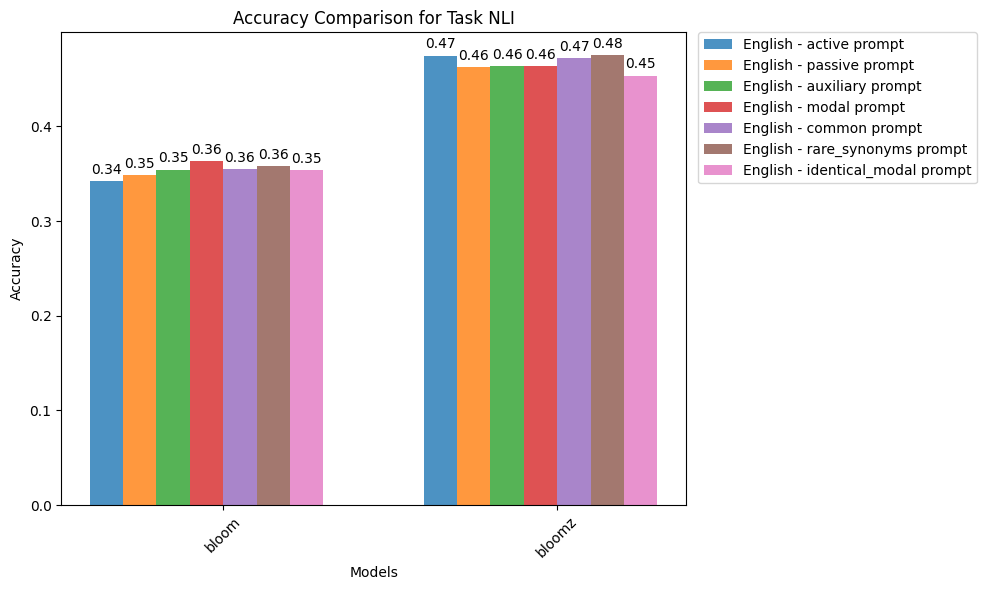

------------- Acc plots------------


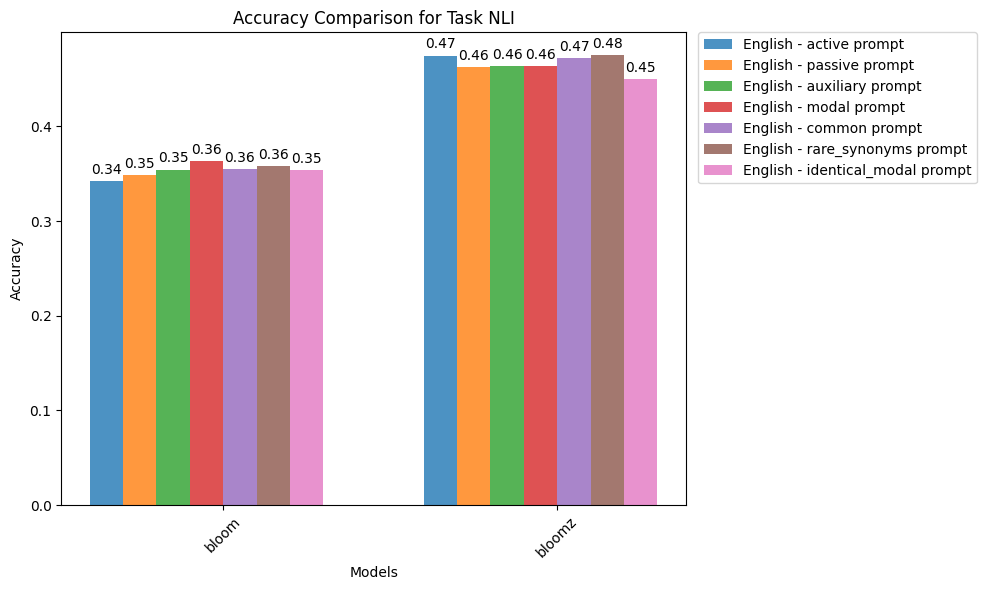

------------- Acc box plots------------


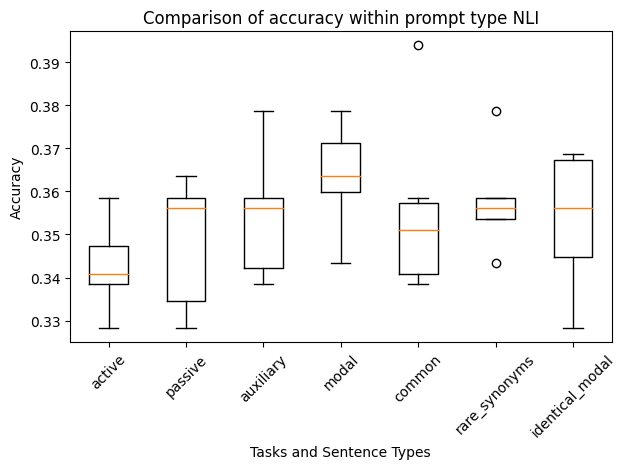

-------------Friedman test------------
acc one prompt type len(var_for_each_prompt) 6
[[0.3383838383838384], [0.3484848484848485], [0.3434343434343434], [0.3383838383838384], [0.35858585858585856], [0.3282828282828283]]
Friedman chi-square score: 4.999999999999997
p-value: 0.4158801869955082
-------------Wilcoxon test------------
Test Statistic: 0.0
p-value: 1.0


In [ ]:
# evaluation settings
models = ['bloom', 'bloomz']#, 'flan', 'llama']  # , 'alpaca']
# LM_models = ['bloom']
tasks = ['NLI']
prompt_types = ['active', 'passive', 'auxiliary',
                    'modal', 'common', 'rare_synonyms', 'identical_modal']
# prompt_types = ['active', 'passive']
# languages = ['en', 'de']
languages = ['en']
# seeds = ['42', '33', '50']
seeds = ['42']

batch_size = 16
sample_size = 200
num_prompts = 6
version=3
task = 'SA'
seed = '42'
lang='en'

yes= 'yes'
no= 'no'
maybe= 'maybe'

model='bloom'
prompt_type1='active'
prompt_type2='passive'

# list of dictionaries
boxplots = [{'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': yes},

            {'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': no},

            {'type': 'all', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},
            
            {'type': 'one_per', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42'}]

box_plot_names = ['Diff conditioned yes', 'Diff conditioned no',
                    'Diff all sentences', 'Diff one sentence', 'Diff one sentence per prompt']



def vis_pipeline_nli(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2):

    print('-------------Label distribution------------')
    task='NLI'
    yes_no_split('true',yes, lang, model, task)
    yes_no_split('true',no,lang,  model, task)
    yes_no_split('true',maybe,lang, model, task)

    print('-------------Prediction distribution------------')
    yes_no_split('pred',yes, lang, model, task)
    yes_no_split('pred',no, lang, model, task)
    yes_no_split('pred',maybe,lang, model, task)

    print('------------- Acc plots------------')
    get_acc_plot(data, languages, models, prompt_types,
                task, seed, version, fn=get_acc_from_logits_nli)
    
    print('------------- Acc plots------------')
    get_acc_plot(data, languages, models, prompt_types,
                task, seed, version, fn=get_acc_from_logits)
    
    print('------------- Acc box plots------------')
    get_acc_box_plot(data, lang, model, prompt_types,task, seed)
    
    # print('-------------Box plots------------')
    # get_box_plot(data,lang, boxplots, box_plot_names, version)

    print('-------------Friedman test------------')
    get_friedman_test(data, model,task, lang,prompt_type1)

    print('-------------Wilcoxon test------------')
    try:
        get_wilcoxon_test(data, model,task, lang,prompt_type1, prompt_type2)
    except Exception as e:
        # Handle the exception here
        print("An error occurred while testing wilcoxon")


vis_pipeline(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2)

-------------Label distribution------------
yes 600
no 600
-------------Prediction distribution------------
yes 1104
no 96
------------- Acc plots------------


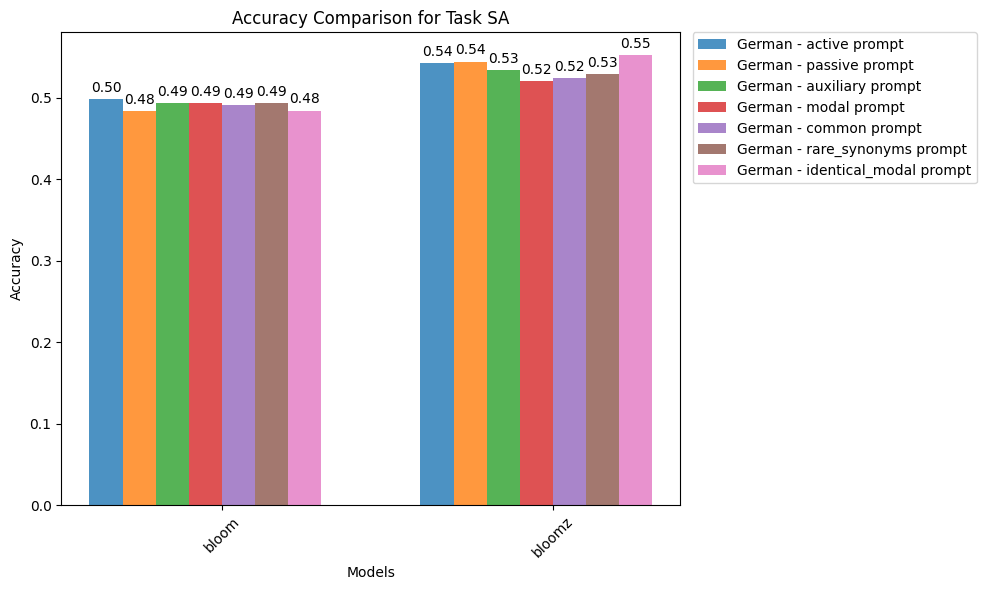

------------- Acc box plots------------


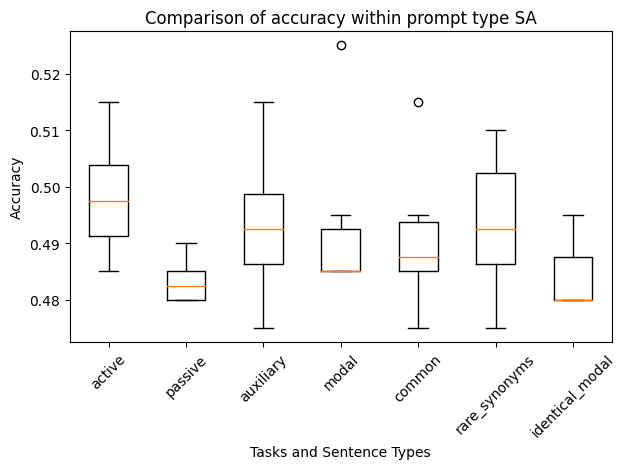

-------------Friedman test------------
acc one prompt type len(var_for_each_prompt) 6
[[0.505], [0.5], [0.515], [0.485], [0.495], [0.49]]
Friedman chi-square score: 5.0
p-value: 0.4158801869955079
-------------Wilcoxon test------------
Test Statistic: 0.0
p-value: 1.0


In [ ]:
# evaluation settings
models = ['bloom', 'bloomz']#, 'llama']#, 'flan', 'llama']  # , 'alpaca']
# LM_models = ['bloom']
tasks = ['SA']
prompt_types = ['active', 'passive', 'auxiliary',
                    'modal', 'common', 'rare_synonyms', 'identical_modal']
# prompt_types = ['active', 'passive']
# languages = ['en', 'de']
languages = ['de']
# seeds = ['42', '33', '50']
seeds = ['42']

batch_size = 16
sample_size = 200
num_prompts = 6
version=3
task = 'SA'
seed = '42'
lang='de'

yes= 'yes'
no= 'no'
maybe= 'maybe'

model='bloom'
prompt_type1='active'
prompt_type2='passive'

# list of dictionaries
boxplots = [{'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': yes},

            {'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': no},

            {'type': 'all', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},
            
            {'type': 'one_per', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42'}]

box_plot_names = ['Diff conditioned yes', 'Diff conditioned no',
                    'Diff all sentences', 'Diff one sentence', 'Diff one sentence per prompt']



def vis_pipeline(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2):

    print('-------------Label distribution------------')
    task='SA'
    yes_no_split('true',yes, lang, model, task)
    yes_no_split('true',no, lang, model, task)

    print('-------------Prediction distribution------------')
    yes_no_split('pred',yes, lang, model, task)
    yes_no_split('pred',no, lang,  model, task)

    print('------------- Acc plots------------')
    get_acc_plot(data, languages, models, prompt_types,
                task, seed, version, fn=get_acc_from_logits)
    
    print('------------- Acc box plots------------')
    get_acc_box_plot(data, lang, model, prompt_types,task, seed)
    
    
    # print('-------------Box plots------------')
    # get_box_plot(data,lang, boxplots, box_plot_names, version)

    print('-------------Friedman test------------')
    get_friedman_test(data, model,task, lang,prompt_type1)

    print('-------------Wilcoxon test------------')
    try:
        get_wilcoxon_test(data, model,task, lang,prompt_type1, prompt_type2)
    except Exception as e:
        # Handle the exception here
        print("An error occurred while testing wilcoxon")


vis_pipeline(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2)

-------------Label distribution------------
yes 396
no 396
maybe 396
-------------Prediction distribution------------
yes 443
no 32
maybe 713
------------- Acc plots------------


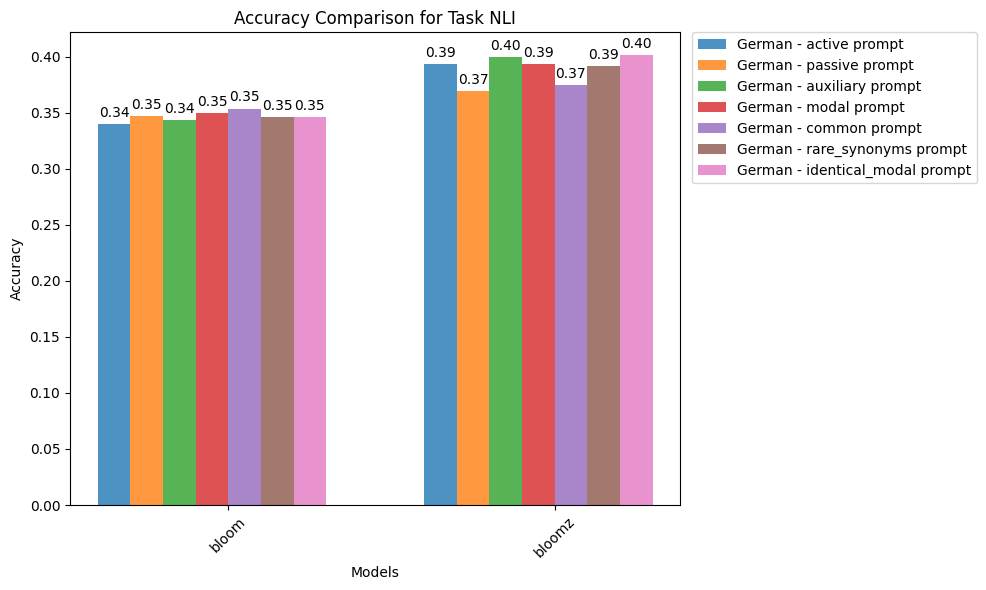

------------- Acc box plots------------


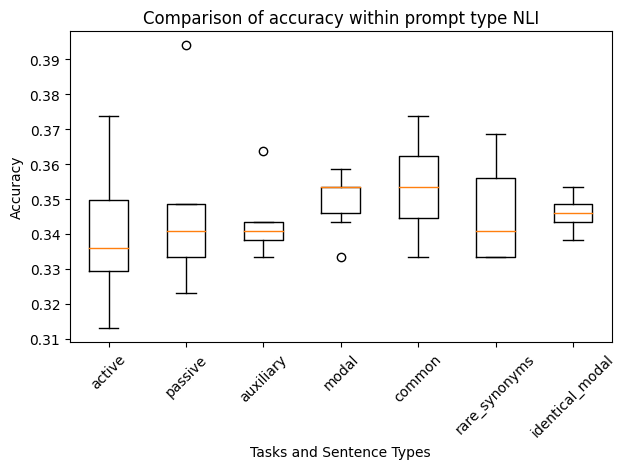

-------------Friedman test------------
acc one prompt type len(var_for_each_prompt) 6
[[0.3383838383838384], [0.31313131313131315], [0.3282828282828283], [0.37373737373737376], [0.35353535353535354], [0.3333333333333333]]
Friedman chi-square score: 5.0
p-value: 0.4158801869955079
-------------Wilcoxon test------------
Test Statistic: 0.0
p-value: 1.0


In [ ]:
# evaluation settings
models = ['bloom', 'bloomz']#, 'flan', 'llama']  # , 'alpaca']
# LM_models = ['bloom']
tasks = ['NLI']
prompt_types = ['active', 'passive', 'auxiliary',
                    'modal', 'common', 'rare_synonyms', 'identical_modal']
# prompt_types = ['active', 'passive']
# languages = ['en', 'de']
languages = ['de']
# seeds = ['42', '33', '50']
seeds = ['42']

batch_size = 16
sample_size = 200
num_prompts = 6
version=3
task = 'SA'
seed = '42'
lang='de'

yes= 'yes'
no= 'no'
maybe= 'maybe'

model='bloom'
prompt_type1='active'
prompt_type2='passive'

# list of dictionaries
boxplots = [{'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': yes},

            {'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': no},

            {'type': 'all', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},
            
            {'type': 'one_per', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42'}]

box_plot_names = ['Diff conditioned yes', 'Diff conditioned no',
                    'Diff all sentences', 'Diff one sentence', 'Diff one sentence per prompt']



def vis_pipeline(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2):

    print('-------------Label distribution------------')
    task='NLI'
    yes_no_split('true',yes, lang, model, task)
    yes_no_split('true',no,lang,  model, task)
    yes_no_split('true',maybe,lang, model, task)

    print('-------------Prediction distribution------------')
    yes_no_split('pred',yes, lang, model, task)
    yes_no_split('pred',no, lang, model, task)
    yes_no_split('pred',maybe,lang, model, task)

    print('------------- Acc plots------------')
    get_acc_plot(data, languages, models, prompt_types,
                task, seed, version, fn=get_acc_from_logits_nli)
    
    print('------------- Acc box plots------------')
    get_acc_box_plot(data, lang, model, prompt_types,task, seed)
    
    # print('-------------Box plots------------')
    # get_box_plot(data,lang, boxplots, box_plot_names, version)

    print('-------------Friedman test------------')
    get_friedman_test(data, model,task, lang,prompt_type1)

    print('-------------Wilcoxon test------------')
    try:
        get_wilcoxon_test(data, model,task, lang,prompt_type1, prompt_type2)
    except Exception as e:
        # Handle the exception here
        print("An error occurred while testing wilcoxon")


vis_pipeline(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2)

-------------Label distribution------------
yes 600
no 600
-------------Prediction distribution------------
yes 843
no 357
------------- Acc plots------------


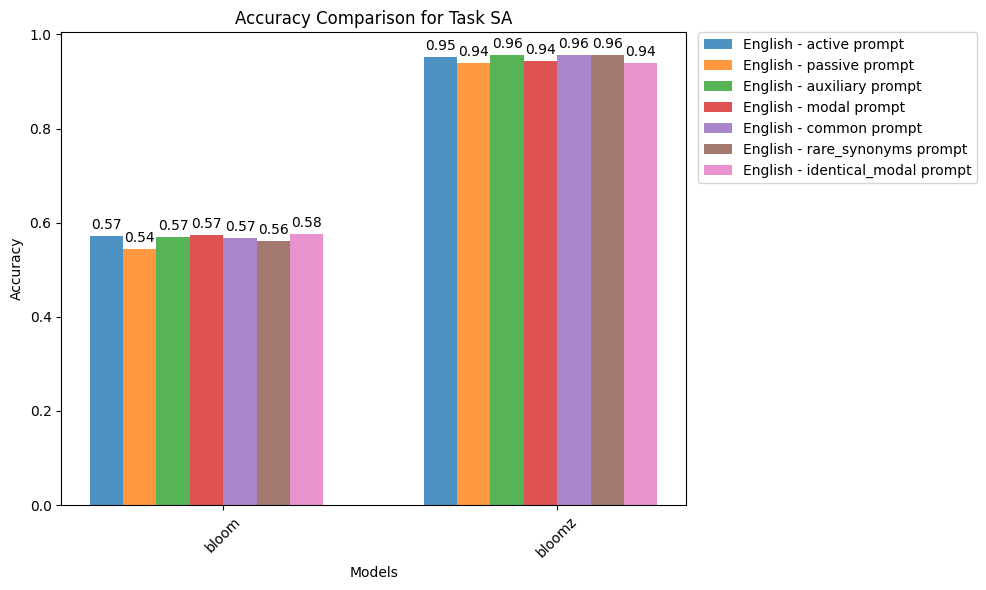

------------- Acc box plots------------


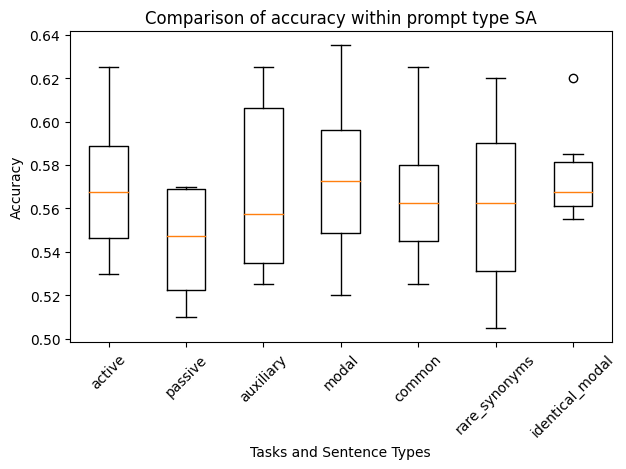

-------------Box plots------------
conditioned yes len(var_for_each_prompt) 843
conditioned no len(var_for_each_prompt) 357
all sents len(var_for_each_prompt) 1200
one sent len(var_for_each_prompt) 6
all_prompt_types dict_keys(['active', 'passive', 'auxiliary', 'modal', 'common', 'rare_synonyms', 'identical_modal'])
one per type len(var_for_each_prompt) 42


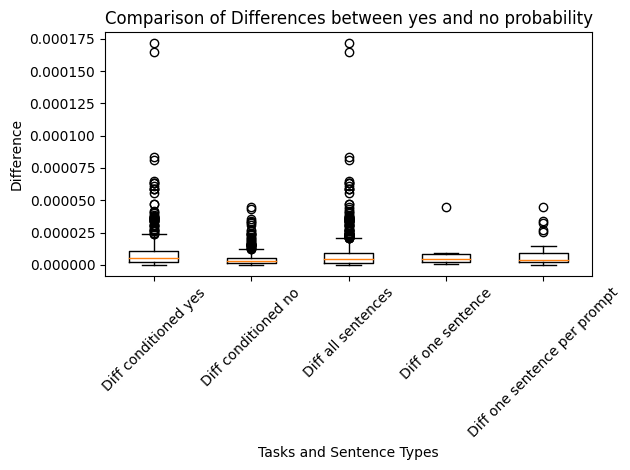

-------------Friedman test------------
one sent len(var_for_each_prompt) 6
[[9.301632417191286e-06], [4.4595486542675644e-05], [5.743549991166219e-07], [2.4028677216847427e-06], [6.766956175852101e-06], [1.8747232388705015e-06]]
Friedman chi-square score: 5.0
p-value: 0.4158801869955079
-------------Wilcoxon test------------
Test Statistic: 0.0
p-value: 1.0
-------------Label distribution------------
yes 396
no 396
maybe 396
-------------Prediction distribution------------
yes 453
no 735
maybe 0
------------- Acc plots------------


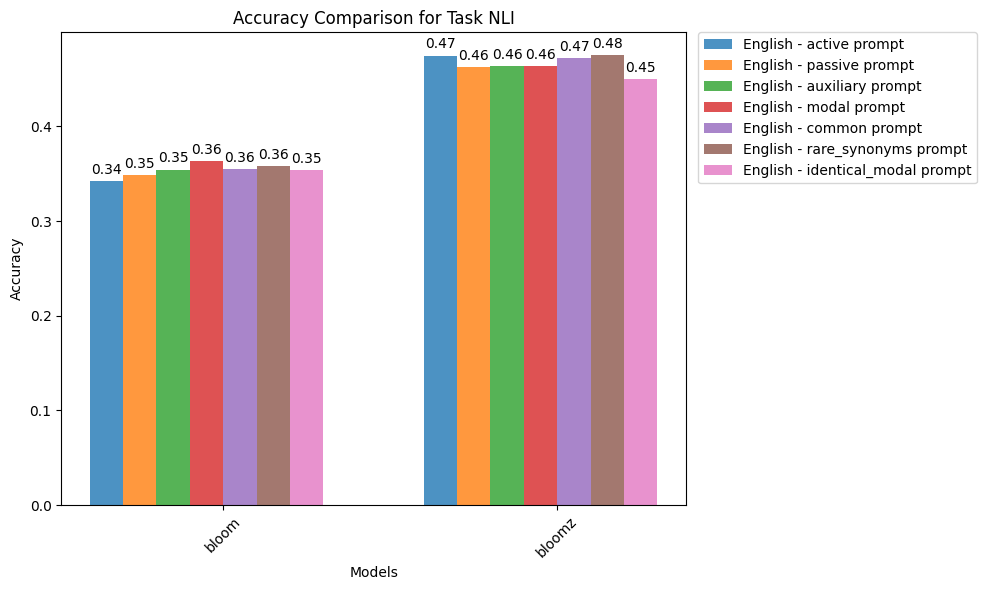

------------- Acc box plots------------


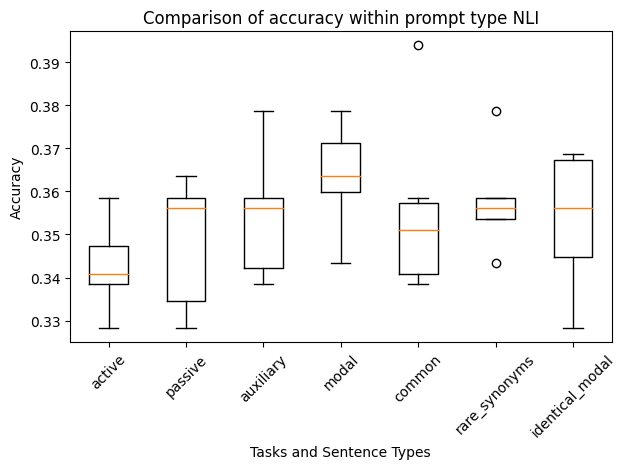

-------------Box plots------------
conditioned yes len(var_for_each_prompt) 843
conditioned no len(var_for_each_prompt) 357
all sents len(var_for_each_prompt) 1200
one sent len(var_for_each_prompt) 6
all_prompt_types dict_keys(['active', 'passive', 'auxiliary', 'modal', 'common', 'rare_synonyms', 'identical_modal'])
one per type len(var_for_each_prompt) 42


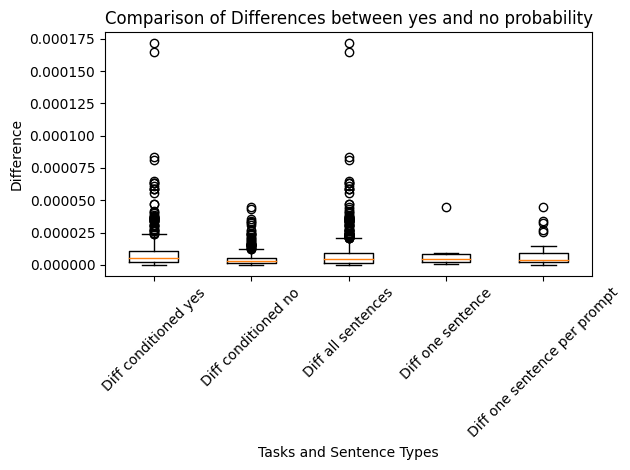

-------------Friedman test------------
one sent len(var_for_each_prompt) 6
[[3.6360070225782692e-06], [2.3340695406659506e-05], [6.303229019977152e-05], [5.248265551927034e-06], [2.386304913670756e-05], [2.9994325814186595e-05]]
Friedman chi-square score: 5.0
p-value: 0.4158801869955079
-------------Wilcoxon test------------
Test Statistic: 0.0
p-value: 1.0


In [ ]:
# evaluation settings
models = ['bloom', 'bloomz']#, 'flan', 'llama']  # , 'alpaca']
# LM_models = ['bloom']
tasks = ['SA', 'NLI']
prompt_types = ['active', 'passive', 'auxiliary',
                    'modal', 'common', 'rare_synonyms', 'identical_modal']
# prompt_types = ['active', 'passive']
# languages = ['en', 'de']
languages = ['en']
# seeds = ['42', '33', '50']
seeds = ['42']

batch_size = 16
sample_size = 200
num_prompts = 6
version=3
task = 'SA'
seed = '42'
lang='en'

yes= 'yes'
no= 'no'
maybe= 'maybe'

model='bloom'
prompt_type1='active'
prompt_type2='passive'

# list of dictionaries
boxplots = [{'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': yes},

            {'type': 'conditioned', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': no},

            {'type': 'all', 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},
            
            {'type': 'one_per', 'sen_id': 1, 'model': model, 'task': task, 'lang': lang,
                'seed': '42'}]

box_plot_names = ['Diff conditioned yes', 'Diff conditioned no',
                    'Diff all sentences', 'Diff one sentence', 'Diff one sentence per prompt']



def vis_pipeline(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2):
    


    print('-------------Label distribution------------')
    task='SA'
    yes_no_split('true',yes, lang, model, task)
    yes_no_split('true',no, lang, model, task)

    print('-------------Prediction distribution------------')
    yes_no_split('pred',yes, lang, model, task)
    yes_no_split('pred',no, lang,  model, task)

    print('------------- Acc plots------------')
    get_acc_plot(data, languages, models, prompt_types,
                task, seed, version, fn=get_acc_from_logits)
    
    print('------------- Acc box plots------------')
    get_acc_box_plot(data, lang, model, prompt_types,task, seed)
    
    
    print('-------------Box plots------------')
    get_box_plot(data,lang, boxplots, box_plot_names, version)

    print('-------------Friedman test------------')
    get_friedman_test(data, model,task, lang,prompt_type1)

    print('-------------Wilcoxon test------------')
    try:
        get_wilcoxon_test(data, model,task, lang,prompt_type1, prompt_type2)
    except Exception as e:
        # Handle the exception here
        print("An error occurred while testing wilcoxon")

    ###########################################

    print('-------------Label distribution------------')
    task='NLI'
    yes_no_split('true',yes, lang, model, task)
    yes_no_split('true',no,lang,  model, task)
    yes_no_split('true',maybe,lang, model, task)

    print('-------------Prediction distribution------------')
    yes_no_split('pred',yes, lang, model, task)
    yes_no_split('pred',no, lang, model, task)
    yes_no_split('pred',maybe,lang, model, task)

    print('------------- Acc plots------------')
    get_acc_plot(data, languages, models, prompt_types,
                task, seed, version, fn=get_acc_from_logits)
    
    print('------------- Acc box plots------------')
    get_acc_box_plot(data, lang, model, prompt_types,task, seed)
    
    print('-------------Box plots------------')
    get_box_plot(data,lang, boxplots, box_plot_names, version)

    print('-------------Friedman test------------')
    get_friedman_test(data, model,task, lang,prompt_type1)

    print('-------------Wilcoxon test------------')
    try:
        get_wilcoxon_test(data, model,task, lang,prompt_type1, prompt_type2)
    except Exception as e:
        # Handle the exception here
        print("An error occurred while testing wilcoxon")


vis_pipeline(data, boxplots, box_plot_names, model, prompt_type1, prompt_type2)

# Accuracy Visualization

In [ ]:
# file_path = 'logits_dict_seed_42_lang_de_v3_4.txt'

# # Save the code snippet to the text file
# with open(file_path, 'w+') as file:
#     for key, value in data.items():
#         file.write(f'{key}: {value}\n')

In [ ]:
import matplotlib.pyplot as plt
import pickle
import torch

import statistics
from matplotlib import pyplot as plt
import numpy as np
from functools import reduce
import io

#contents = pickle.load(f) becomes...
# contents = CPU_Unpickler(f).load()

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        return super().find_class(module, name)

def open_data_pickle(filename):
    with open(filename, 'rb') as f:
        data = CPU_Unpickler(f).load()
    return data

filename= 'logits_dict_seed_42_lang_de_v3.pickle'
data =open_data_pickle(filename= filename)
batch = data['42']['de']['bloom']['SA']['active']['prompt_id_1'] #sample_size
# print(batch)
# print(data)
# print()

def merge_dicts(dict1, dict2):
    for key, value in dict2.items():
        if key in dict1:
            merge_dicts(dict1[key], dict2[key])
        else:
            dict1[key] = value
    return dict1

data = merge_dicts(open_data_pickle(filename= 'logits_dict_seed_42_lang_de_v3.pickle'),  open_data_pickle(filename= 'logits_dict_seed_42_lang_de_v4.pickle'))
# print(data)

{0: {'yes': 0.0, 'no': 2.551523175498005e-05, 'diff': 2.551523175498005e-05, 'pred': 'nein', 'true': 'ja'}, 1: {'yes': 0.0, 'no': 2.491614577593282e-05, 'diff': 2.491614577593282e-05, 'pred': 'nein', 'true': 'nein'}, 2: {'yes': 0.0, 'no': 2.208256410085596e-05, 'diff': 2.208256410085596e-05, 'pred': 'nein', 'true': 'nein'}, 3: {'yes': 0.0, 'no': 2.471544939908199e-05, 'diff': 2.471544939908199e-05, 'pred': 'nein', 'true': 'ja'}, 4: {'yes': 0.0, 'no': 2.01206021301914e-05, 'diff': 2.01206021301914e-05, 'pred': 'nein', 'true': 'ja'}, 5: {'yes': 0.0, 'no': 1.7087484593503177e-05, 'diff': 1.7087484593503177e-05, 'pred': 'nein', 'true': 'ja'}, 6: {'yes': 0.0, 'no': 2.4151820980478078e-05, 'diff': 2.4151820980478078e-05, 'pred': 'nein', 'true': 'ja'}, 7: {'yes': 0.0, 'no': 2.400566518190317e-05, 'diff': 2.400566518190317e-05, 'pred': 'nein', 'true': 'nein'}, 8: {'yes': 0.0, 'no': 1.663403418206144e-05, 'diff': 1.663403418206144e-05, 'pred': 'nein', 'true': 'ja'}, 9: {'yes': 0.0, 'no': 3.1507

In [ ]:
# how many samples where yes and no (true label)

def yes_no_split(key, condition, model, task,prompt_type='active'):
    var_for_each_prompt=[]
    path = ['42', 'de', model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    answer_map= {'ja':'yes', 'nein':'no', 'vielleicht': 'maybe'}
    for i in range(num_prompt_vars):
        num_sentences = len(
            reduce(lambda d, k: d[k], path + [f'prompt_id_{i}'], data))-1
        for sen_id in range(num_sentences):
            sentence = reduce(
                lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
            if sentence[key] == condition:
                var = sentence[answer_map[condition]]
                var_for_each_prompt.append(var)
    print(condition, len(var_for_each_prompt))

print('-------------Label distribution------------')
model='bloom'
task='SA'
yes_no_split('true','ja', model, task)
yes_no_split('true','nein', model, task)

task='NLI'
yes_no_split('true','ja', model, task)
yes_no_split('true','nein', model, task)
yes_no_split('true','vielleicht', model, task)

print('-------------Prediction distribution------------')
model='bloom'
task='SA'
yes_no_split('pred','ja', model, task)
yes_no_split('pred','nein', model, task)

task='NLI'
yes_no_split('pred','ja', model, task)
yes_no_split('pred','nein', model, task)
yes_no_split('pred','vielleicht', model, task)

-------------Label distribution------------
ja 75
nein 75
ja 48
nein 48
vielleicht 48
-------------Prediction distribution------------
ja 0
nein 150
ja 0
nein 144
vielleicht 0


In [ ]:

class AccuracyVisualizer:
    def __init__(self, data, models, languages, prompts, task):
        self.data = data
        self.models = models
        lang_map = {'en': 'English', 'de': 'German'}
        self.languages = [lang_map[lang] for lang in languages]
        self.prompts = prompts
        self.task = task

    def visualize(self, file='./ATCS_group3/saved_outputs/Accuracies_v1.png'):
        space_between_bars = 0.15  # Adjust the value as needed
        opacity = 0.8
        x_pos = np.arange(len(self.models))
        model_offset = space_between_bars * (len(self.languages) * len(self.prompts) - 1)

        fig, ax = plt.subplots(figsize=(10, 6)) 

        for i, language in enumerate(self.languages):
            for j, prompt in enumerate(self.prompts):
                accuracies = self.data[(language, prompt)]
                offsets = x_pos + \
                    (i * model_offset) + (j * space_between_bars)
                bar = ax.bar(offsets, accuracies, space_between_bars, alpha=opacity,
                    label=f'{language} - {prompt} prompt')
                
                self.autolabel(bar, ax)

        ax.set_xticks(x_pos + (model_offset / 2))
        ax.set_xticklabels(self.models, rotation=45)
        ax.set_xlabel('Models')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Accuracy Comparison for Task {self.task}')
        
        # Move the legend outside the plot
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
        # ax.legend()

        plt.tight_layout()
        plt.show()
        plt.close()  # Close the figure to free up memory

    def autolabel(self, bars, ax):
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3), textcoords='offset points',
                            ha='center', va='bottom')
                
                
def get_acc_from_logits(data, model='bloom', task='SA', lang='en', seed='42', prompt_type='active'):
    """
    Computes accuracy given predicted and target labels
    input:
        predictions: a list of predicted labels
        targets: a list of true labels
    output:
        accuracy: float value of the classification accuracy
    """
    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    targets = []
    predictions = []
    for i in range(num_prompt_vars):
        num_sentences = len(
            reduce(lambda d, k: d[k], path + [f'prompt_id_{i}'], data))-1
        for sen_id in range(num_sentences):
            sentence = reduce(
                lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
            pred = sentence['pred']
            true = sentence['true']
            targets.append(true)
            predictions.append(pred)

    correct = sum(pred == true for pred, true in zip(predictions, targets))
    total = len(predictions)
    accuracy = correct / total

    return accuracy


def get_acc_from_logits2(data, model='bloom', task='SA', lang='en', seed='42', prompt_type='active'):
    """
    Computes accuracy given predicted and target labels
    input:
        predictions: a list of predicted labels
        targets: a list of true labels
    output:
        accuracy: float value of the classification accuracy
    """
    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    mean_prompt_type_acc = 0
    for i in range(num_prompt_vars):
        prompt_dict = reduce(
            lambda d, k: d[k], path + [f'prompt_id_{i}'], data)
        acc = prompt_dict['acc']
        mean_prompt_type_acc += acc

    mean_prompt_type_acc = mean_prompt_type_acc / num_prompt_vars

    return mean_prompt_type_acc

def get_acc_from_logits3(data, model='bloom', task='SA', lang='en', seed='42', prompt_type='active'):
    """
    Computes accuracy per prompt type and per prompt id within
    input:
        predictions: a list of predicted labels
        targets: a list of true labels
    output:
        accuracy: float value of the classification accuracy
    """
    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    list_prompt_type_acc = []
    for i in range(num_prompt_vars):
        prompt_dict = reduce(
            lambda d, k: d[k], path + [f'prompt_id_{i}'], data)
        acc = prompt_dict['acc']
        list_prompt_type_acc.append(acc)

    return list_prompt_type_acc



def get_acc_plot(data, languages, models, prompt_types, task, seed, version, fn=get_acc_from_logits):
    lang_map = {'en': 'English', 'de': 'German'}

    plot_data = {}
    for lang in languages:
        for LM_model in models:
            for prompt_type in prompt_types:
                key = (lang_map[lang], prompt_type)
                if key in plot_data:
                    # print('key', key)
                    if fn == get_acc_from_logits3:
                        plot_data[key].extend(fn(
                            data, model=LM_model, task=task, lang=lang, seed=seed, prompt_type=prompt_type))
                    else:
                        # Append data to existing key
                        plot_data[key].append(fn(
                            data, model=LM_model, task=task, lang=lang, seed=seed, prompt_type=prompt_type))
                else:
                    if fn == get_acc_from_logits3:
                        plot_data[key]=fn(
                            data, model=LM_model, task=task, lang=lang, seed=seed, prompt_type=prompt_type)
                    else:
                        # Create new key and assign data
                        plot_data[key] = [fn(
                            data, model=LM_model, task=task, lang=lang, seed=seed, prompt_type=prompt_type)]

    visualizer = AccuracyVisualizer(
        plot_data, models, languages, prompt_types, task)
    visualizer.visualize(file=f'Accuracies_v{version}_{fn}.png')



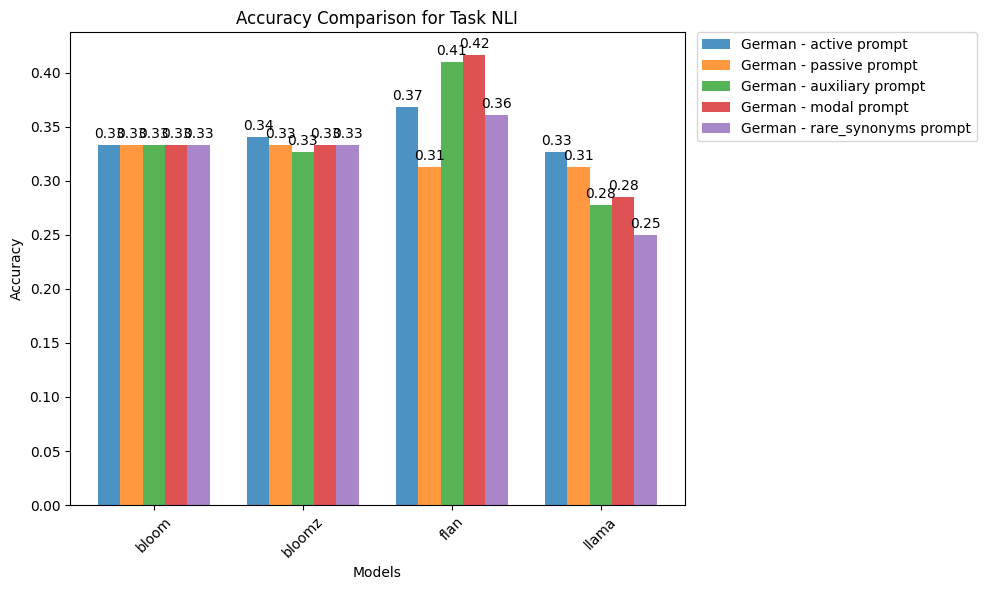

In [ ]:
get_acc_plot(data, languages, models, prompt_types,
                task, seed, version, fn=get_acc_from_logits)

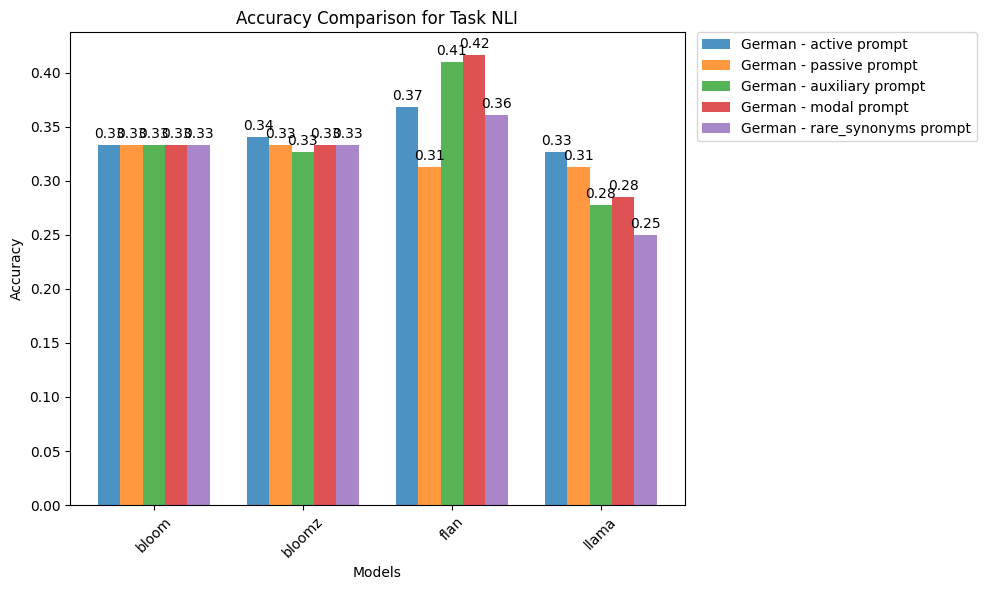

In [ ]:
get_acc_plot(data, languages, models, prompt_types,
                'NLI', seed, version, fn=get_acc_from_logits)

# Box Plots

In [ ]:
class BoxPlotVisualizer:
    def __init__(self, data):
        self.data = data

    def visualize(self, box_plot_names, num_plots, file=f'Box_plots_v1.png'):
        fig, ax = plt.subplots()
        ax.boxplot(self.data)
        ax.set_xlabel('Tasks and Sentence Types')
        ax.set_ylabel('Difference')
        ax.set_title(
            'Comparison of Differences between yes and no probability')
        ax.set_xticks(num_plots)
        ax.set_xticklabels(box_plot_names, rotation=45)

        plt.tight_layout()
        plt.show()
        plt.close()  # Close the figure to free up memory


def one_sentence_boxplot(data, sen_id, model='bloom', task='SA', lang='en', seed='42', prompt_type='active'):
    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    var_for_each_prompt = []
    for i in range(num_prompt_vars):
        sentence = reduce(
            lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
        var = sentence['diff']
        var_for_each_prompt.append(var)
    print('len(var_for_each_prompt)', len(var_for_each_prompt))
    return var_for_each_prompt

def one_sentence_per_type_boxplot(data, sen_id, model='bloom', task='SA', lang='en', seed='42'):
    path = [seed, lang, model, task]
    all_prompt_types = reduce(lambda d, k: d[k], path, data)
    print('all_prompt_types', all_prompt_types.keys())
    num_prompt_types = len(all_prompt_types.keys())

    var_for_each_prompt = []
    for i in range(num_prompt_types):
        prompt_type = list(all_prompt_types.keys())[i]
        num_prompt_vars = len(reduce(lambda d, k: d[k], path + [prompt_type], data))
        for i in range(num_prompt_vars):
            sentence = reduce(
                lambda d, k: d[k], path+ [prompt_type] + [f'prompt_id_{i}', sen_id], data)
            var = sentence['diff']
            var_for_each_prompt.append(var)
            
    print('len(var_for_each_prompt)', len(var_for_each_prompt))
    return var_for_each_prompt

def all_sentence_boxplot(data, model='bloom', task='SA', lang='en', seed='42', prompt_type='active'):
    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    var_for_each_prompt = []
    for i in range(num_prompt_vars):
        num_sentences = len(
            reduce(lambda d, k: d[k], path + [f'prompt_id_{i}'], data))-1
        for sen_id in range(num_sentences):
            sentence = reduce(
                lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
            var = sentence['diff']
            var_for_each_prompt.append(var)
    print('len(var_for_each_prompt)', len(var_for_each_prompt))
    return var_for_each_prompt


def conditioned_all_sentence_boxplot(data, model='bloom', task='SA', lang='en', seed='42', prompt_type='active', condition='yes'):
    path = [seed, lang, model, task, prompt_type]
    all_prompt_vars = reduce(lambda d, k: d[k], path, data)
    num_prompt_vars = len(all_prompt_vars.keys())

    var_for_each_prompt = []
    for i in range(num_prompt_vars):
        num_sentences = len(
            reduce(lambda d, k: d[k], path + [f'prompt_id_{i}'], data))-1
        for sen_id in range(num_sentences):
            sentence = reduce(
                lambda d, k: d[k], path + [f'prompt_id_{i}', sen_id], data)
            if sentence['pred'] == condition:
                var = sentence['diff']
                var_for_each_prompt.append(var)
    print('len(var_for_each_prompt)', len(var_for_each_prompt))
    return var_for_each_prompt


def get_box_plot(boxplots, box_plot_names, version, file_path='logits_dict.pickle'):
    # this function expects boxplots to be a list of dictionaries
    data =open_data_pickle(filename= file_path)

    plot_data = []
    for boxplot in boxplots:
        plot_type = boxplot['type']
        # print(boxplot)
        if plot_type == 'conditioned':
            plot_data.append(conditioned_all_sentence_boxplot(data, model=boxplot['model'], task=boxplot['task'], lang=boxplot[
                'lang'], seed=boxplot['seed'], prompt_type=boxplot['prompt_type'], condition=boxplot['condition']))
        elif plot_type == 'all':
            plot_data.append(all_sentence_boxplot(data, model=boxplot['model'], task=boxplot['task'],
                                                  lang=boxplot['lang'], seed=boxplot['seed'], prompt_type=boxplot['prompt_type']))
        elif plot_type == 'one':
            plot_data.append(one_sentence_boxplot(data, sen_id=boxplot['sen_id'], model=boxplot['model'],
                                                  task=boxplot['task'], lang=boxplot['lang'], seed=boxplot['seed'], prompt_type=boxplot['prompt_type']))
        elif plot_type == 'one_per':
            plot_data.append(one_sentence_per_type_boxplot(data, sen_id=boxplot['sen_id'], model=boxplot['model'],
                                                  task=boxplot['task'], lang=boxplot['lang'], seed=boxplot['seed']))
        else:
            print(f'There is no boxplot definition for {plot_type}')

    num_plots = [i+1 for i in range(len(box_plot_names))]
    visualizer = BoxPlotVisualizer(plot_data)
    visualizer.visualize(box_plot_names, num_plots,
                         file=f'Box_plots_v{version}.png')


len(var_for_each_prompt) 0
len(var_for_each_prompt) 144
len(var_for_each_prompt) 144
len(var_for_each_prompt) 3
all_prompt_types dict_keys(['active', 'passive', 'auxiliary', 'modal', 'rare_synonyms'])
len(var_for_each_prompt) 15


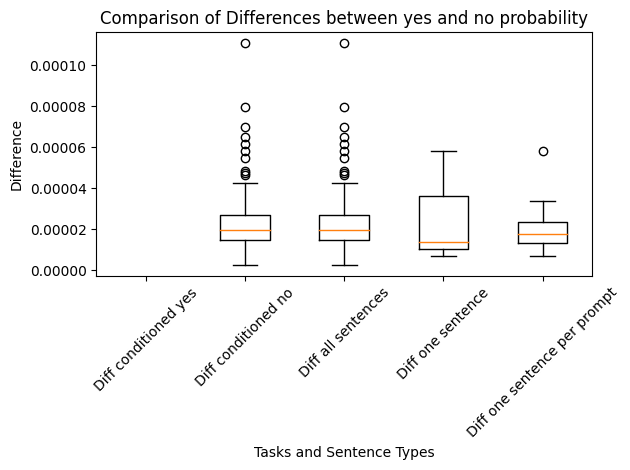

In [ ]:

# list of dictionaries
boxplots = [{'type': 'conditioned', 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': 'ja'},

            {'type': 'conditioned', 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': 'nein'},

            {'type': 'all', 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 1, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},
            
            {'type': 'one_per', 'sen_id': 1, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42'}]

box_plot_names = ['Diff conditioned yes', 'Diff conditioned no',
                    'Diff all sentences', 'Diff one sentence', 'Diff one sentence per prompt']
                    
get_box_plot(boxplots, box_plot_names, version, file_path=file_path)

# English pickle: A lot more yes predictions, this is bad right?
# len(var_for_each_prompt) 113
# len(var_for_each_prompt) 37

# german pickle: A lot more yes predictions, bad!
# len(var_for_each_prompt) 1
# len(var_for_each_prompt) 149

len(var_for_each_prompt) 0
len(var_for_each_prompt) 144
len(var_for_each_prompt) 144
len(var_for_each_prompt) 3
all_prompt_types dict_keys(['active', 'passive', 'auxiliary', 'modal', 'rare_synonyms'])
len(var_for_each_prompt) 15


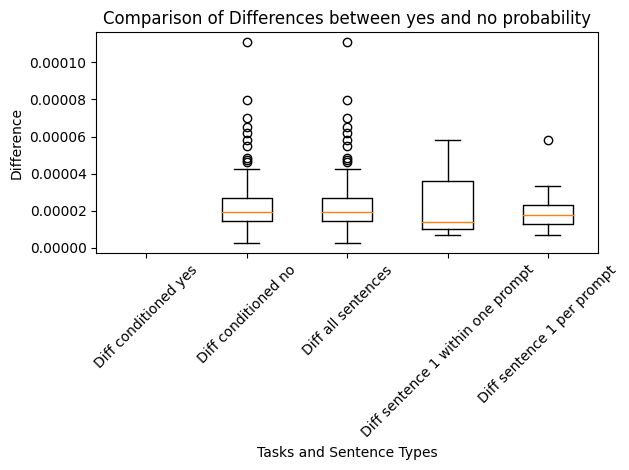

In [ ]:
# list of dictionaries
lang='de'
task = 'NLI'
boxplots = [{'type': 'conditioned', 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active', 'condition': 'ja'},

            {'type': 'conditioned', 'model': 'bloom', 'task': task, 'lang':lang,
                'seed': '42', 'prompt_type': 'active', 'condition': 'nein'},

            {'type': 'all', 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 1, 'model': 'bloom', 'task': task, 'lang':lang,
                'seed': '42', 'prompt_type': 'active'},
            
            {'type': 'one_per', 'sen_id': 1, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42'}]

box_plot_names = ['Diff conditioned yes', 'Diff conditioned no',
                    'Diff all sentences', 'Diff sentence 1 within one prompt', 'Diff sentence 1 per prompt']
                    
get_box_plot(boxplots, box_plot_names, version, file_path=file_path)

len(var_for_each_prompt) 3
len(var_for_each_prompt) 3
len(var_for_each_prompt) 3
len(var_for_each_prompt) 3
len(var_for_each_prompt) 3


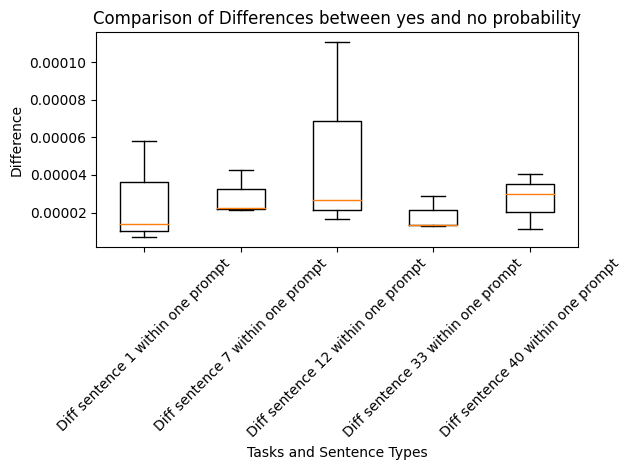

In [ ]:
# look at the variability of one sentence within one prompts
lang='de'
task = 'NLI'
# list of dictionaries
boxplots = [{'type': 'one', 'sen_id': 1, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 7, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 12, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},

            {'type': 'one', 'sen_id': 33, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'},
            
            {'type': 'one', 'sen_id': 40, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': 'active'}]

box_plot_names = ['Diff sentence 1 within one prompt', 'Diff sentence 7 within one prompt',
                    'Diff sentence 12 within one prompt', 'Diff sentence 33 within one prompt', 'Diff sentence 40 within one prompt']
                    
get_box_plot(boxplots, box_plot_names, version, file_path=file_path)

len(var_for_each_prompt) 3
len(var_for_each_prompt) 3
len(var_for_each_prompt) 3
len(var_for_each_prompt) 3
len(var_for_each_prompt) 3


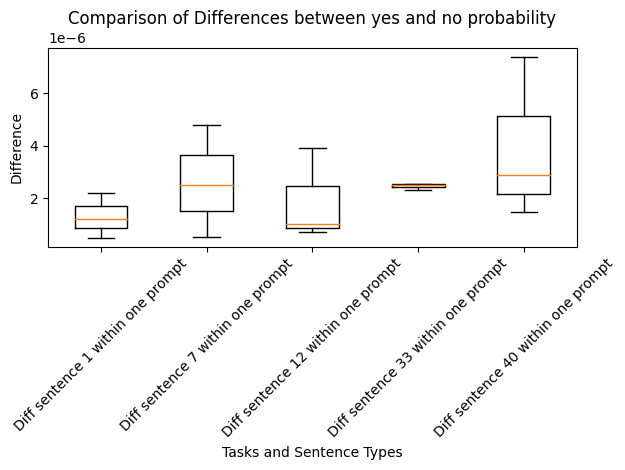

In [ ]:
# look at the variability of one sentence within one prompts
lang='de'
task = 'NLI'
prompt_type='passive'
# list of dictionaries
boxplots = [{'type': 'one', 'sen_id': 1, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': prompt_type},

            {'type': 'one', 'sen_id': 7, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': prompt_type},

            {'type': 'one', 'sen_id': 12, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': prompt_type},

            {'type': 'one', 'sen_id': 33, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': prompt_type},
            
            {'type': 'one', 'sen_id': 40, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42', 'prompt_type': prompt_type}]

box_plot_names = ['Diff sentence 1 within one prompt', 'Diff sentence 7 within one prompt',
                    'Diff sentence 12 within one prompt', 'Diff sentence 33 within one prompt', 'Diff sentence 40 within one prompt']
                    
get_box_plot(boxplots, box_plot_names, version, file_path=file_path)

all_prompt_types dict_keys(['active', 'passive', 'auxiliary', 'modal', 'rare_synonyms'])
len(var_for_each_prompt) 15
all_prompt_types dict_keys(['active', 'passive', 'auxiliary', 'modal', 'rare_synonyms'])
len(var_for_each_prompt) 15
all_prompt_types dict_keys(['active', 'passive', 'auxiliary', 'modal', 'rare_synonyms'])
len(var_for_each_prompt) 15
all_prompt_types dict_keys(['active', 'passive', 'auxiliary', 'modal', 'rare_synonyms'])
len(var_for_each_prompt) 15
all_prompt_types dict_keys(['active', 'passive', 'auxiliary', 'modal', 'rare_synonyms'])
len(var_for_each_prompt) 15


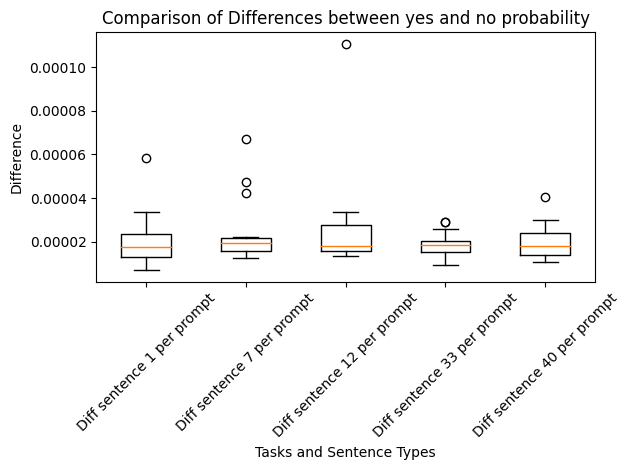

In [ ]:
# look at the variability of one sentence over different prompts
lang='de'
task = 'NLI'
# list of dictionaries
boxplots = [{'type': 'one_per', 'sen_id': 1, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42'},

            {'type': 'one_per', 'sen_id': 7, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42'},

            {'type': 'one_per', 'sen_id': 12, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42'},

            {'type': 'one_per', 'sen_id': 33, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42'},
            
            {'type': 'one_per', 'sen_id': 40, 'model': 'bloom', 'task': task, 'lang': lang,
                'seed': '42'}]

box_plot_names = ['Diff sentence 1 per prompt', 'Diff sentence 7 per prompt',
                    'Diff sentence 12 per prompt', 'Diff sentence 33 per prompt', 'Diff sentence 40 per prompt']
                    
get_box_plot(boxplots, box_plot_names, version, file_path=file_path)

# Significance tests




# extra

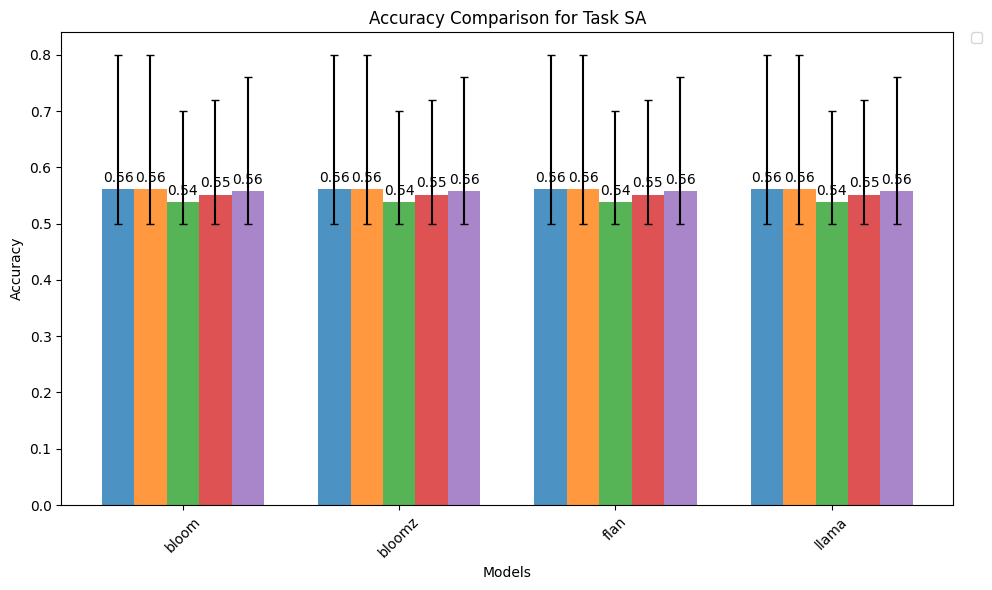

In [ ]:
get_acc_plot(data, languages, models, prompt_types,
                'SA', seed, version, fn=get_acc_from_logits3)